# Phase 0: Setup

## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.stats import norm, chi2_contingency, spearmanr
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    matthews_corrcoef,
    make_scorer,
    f1_score,
    ConfusionMatrixDisplay,
    auc
)
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
import shap

from catboost import CatBoostClassifier, Pool
import catboost.utils

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

import optuna

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate

import joblib
from functools import partial
import os
import time

## Step 2: Data Loading

In [2]:
unclean_test = pd.read_csv('test.csv')
unclean_train = pd.read_csv('train.csv')

# Phase 1: Exploratory & Statistical Testing

## 1.1: Exploratory Data Analysis
Shape of the data, cleaning the data, monovariate charts, bivariate significance, Mann-WHitney U, Correlation heat-map

### Data Description
Samples (rows): 800
Features (cols): 22

Feature Descriptions:

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `ID`                | Unique identifier for each patient                                          |
| `A1_Score` - `A10_Score` | Scores (0 or 1) for each of the 10 AQ screening questions                  |
| `age`               | Age of the patient (in years)                                               |
| `gender`            | Gender of the patient (`m` or `f`)                                          |
| `ethnicity`         | Ethnicity of the patient (12 unique values, e.g., `White-European`)         |
| `jaundice`          | Whether the patient had jaundice at birth (`yes`/`no`)                      |
| `autism`            | Whether an immediate family member has been diagnosed with autism (`yes`/`no`) |
| `contry_of_res`     | Country of residence (56 unique values)                                     |
| `used_app_before`   | Whether the patient has used a screening app before (`yes`/`no`)            |
| `result`            | Composite score for AQ1-10 screening test (float, can be negative)          |
| `age_desc`          | Age description (all values: `18 and more`)                                 |
| `relation`          | Relation of the person completing the test (6 unique values, mostly `Self`)  |
| `Class/ASD`         | Target variable: 0 (No ASD), 1 (ASD)                                        |

In [3]:
unclean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

All of our variables are not null, so we don't need to worry about that

In [4]:
unclean_train.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.0000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,8.537303,0.201250
std,231.0844,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676,0.401185
min,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748,0.000000
25%,200.7500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,5.306575,0.000000
50%,400.5000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,9.605299,0.000000
75%,600.2500,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,12.514484,0.000000
max,800.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,15.853126,1.000000


This gives us some quick stats on each of our numerical features.

Below are the numeric columns separated from the rest of the dataset.

In [5]:
unclean_train.iloc[:,[unclean_train[x].dtype != 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         800 non-null    int64  
 1   A1_Score   800 non-null    int64  
 2   A2_Score   800 non-null    int64  
 3   A3_Score   800 non-null    int64  
 4   A4_Score   800 non-null    int64  
 5   A5_Score   800 non-null    int64  
 6   A6_Score   800 non-null    int64  
 7   A7_Score   800 non-null    int64  
 8   A8_Score   800 non-null    int64  
 9   A9_Score   800 non-null    int64  
 10  A10_Score  800 non-null    int64  
 11  age        800 non-null    float64
 12  result     800 non-null    float64
 13  Class/ASD  800 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 87.6 KB


In [6]:
# Create numerical cols list
num_cols = [unclean_train[x].dtype != 'object' for x in unclean_train]

Do the same for categorical features

In [7]:
unclean_train.iloc[:,[unclean_train[x].dtype == 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           800 non-null    object
 1   ethnicity        800 non-null    object
 2   jaundice         800 non-null    object
 3   austim           800 non-null    object
 4   contry_of_res    800 non-null    object
 5   used_app_before  800 non-null    object
 6   age_desc         800 non-null    object
 7   relation         800 non-null    object
dtypes: object(8)
memory usage: 50.1+ KB


In [8]:
# Create categorical cols list
cat_cols = [unclean_train[x].dtype == 'object' for x in unclean_train]

Diving a bit deeper into the categorical features, we want to see the unique values in those columns.

In [9]:
for item in unclean_train.iloc[:,cat_cols]:   
    print(item)
    print(unclean_test[item].unique(), end="\n")
 

gender
['m' 'f']
ethnicity
['White-European' 'Asian' '?' 'Middle Eastern ' 'South Asian' 'Pasifika'
 'Turkish' 'Latino' 'Black' 'Others' 'Hispanic']
jaundice
['yes' 'no']
austim
['no' 'yes']
contry_of_res
['India' 'Mexico' 'Egypt' 'Italy' 'Australia' 'United States' 'Jordan'
 'Burundi' 'United Kingdom' 'Canada' 'Germany' 'Russia' 'Spain' 'Austria'
 'Iran' 'New Zealand' 'Bolivia' 'United Arab Emirates' 'Uruguay' 'Lebanon'
 'France' 'Netherlands' 'Bahamas' 'Iceland' 'Sri Lanka' 'Afghanistan'
 'Pakistan' 'Malaysia' 'Aruba' 'Ireland' 'Viet Nam' 'Tonga' 'Philippines'
 'Azerbaijan' 'Czech Republic']
used_app_before
['no' 'yes']
age_desc
['18 and more']
relation
['Self' 'Parent' '?' 'Relative' 'Others' 'Health care professional']


Inspecting our data, we determine that we can convert the `gender`, `austim`, `jaundice`, and `used_app_before` features into numerical values. `age_desc` can be discarded, as it only contains a single value.

Let's also check if the categories of traning data are consistent with the test data or not. If they aren't we'll face issues  during training and prediction.

In [10]:
for item in unclean_train.iloc[:,cat_cols]:
    print(item)
    print([x for x in unclean_test[item].unique() if x not in unclean_train[item].unique()],end = "\n")

gender
[]
ethnicity
[]
jaundice
[]
austim
[]
contry_of_res
['Uruguay', 'Lebanon', 'Philippines']
used_app_before
[]
age_desc
[]
relation
[]


We can see that the countries `Uruguay`, `Lebanon`, and `Philippines` are present in the test set but not the training set. This will cause problems, so we'll have to deal with it in the data preparation step.

### Cleaning the Data

**Reasoning**:
- Remove the 'age_desc': All samples have the same entry for this feature, so we can disregard it 
- Remove the 'ID': This is an arbitrary value that has no impact on our dataset
- Changed '?' to 'Unknown': Better readability of the data

In [11]:
train = unclean_train.copy()
test = unclean_test.copy()

# Replace '?' with 'Unknown' in both train and test dataframes
train.replace('?', 'Unknown', inplace=True)
test.replace('?', 'Unknown', inplace=True)

# Fix the misspelled column name 'austim' to 'autism'
train.rename(columns={'austim': 'autism'}, inplace=True)
test.rename(columns={'austim': 'autism'}, inplace=True)

# Remove the 'age_desc' column.
train.drop('age_desc', axis=1, inplace=True)
test.drop('age_desc', axis=1, inplace=True)

# Remove the 'id' column
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

# Check for remaining missing values.
print("\nMissing Values after cleaning:\n", train.isnull().sum())

# Verify the cleaning steps.
display(train.head())
print(train.shape)


Missing Values after cleaning:
 A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
autism             0
contry_of_res      0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,f,Unknown,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,m,Unknown,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,f,Unknown,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,m,Unknown,no,no,South Africa,no,-4.777286,Self,0


(800, 20)


### Univariate Plots

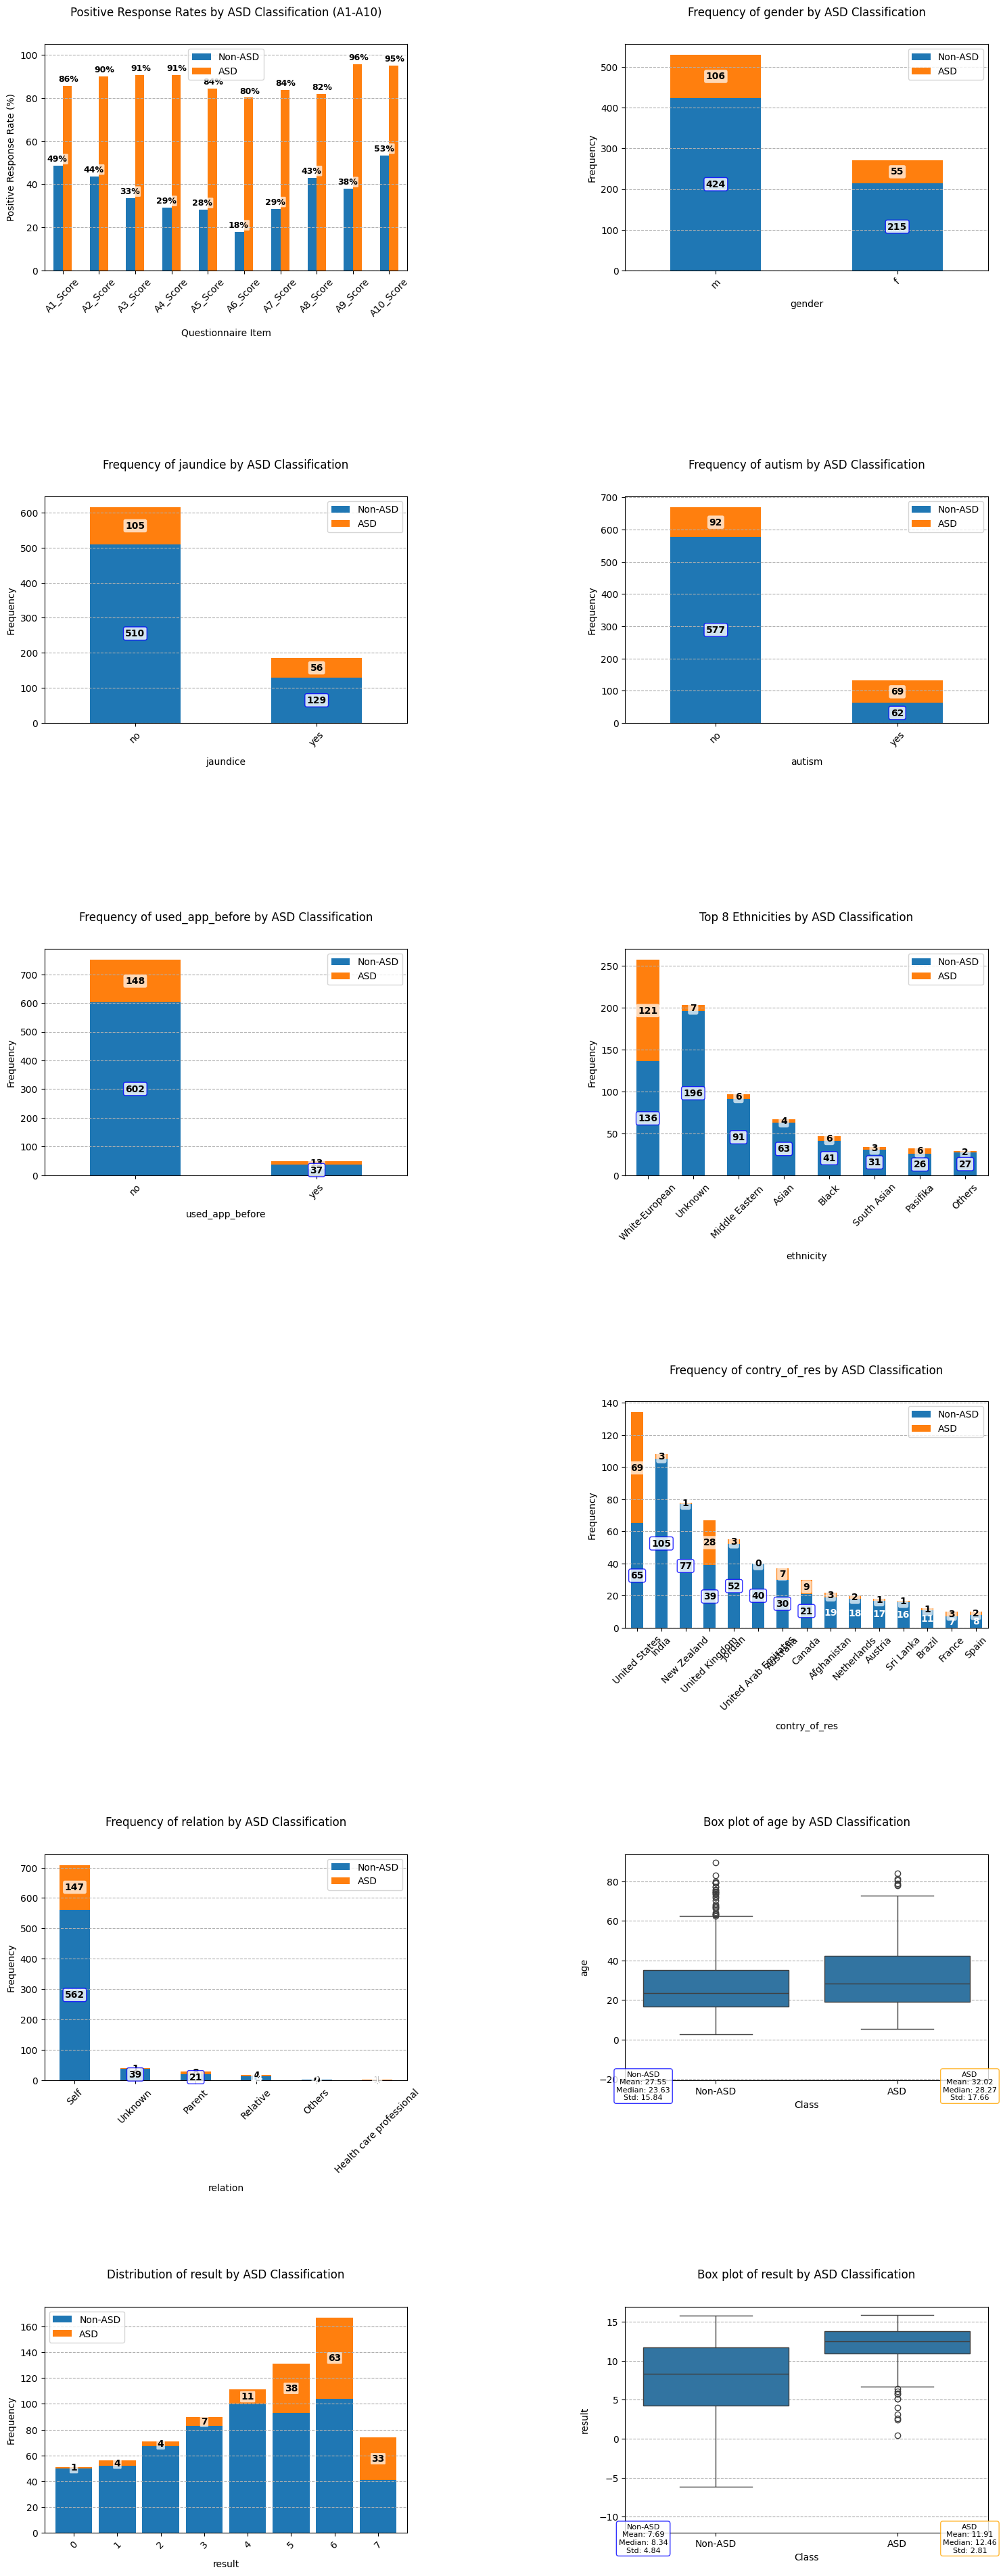

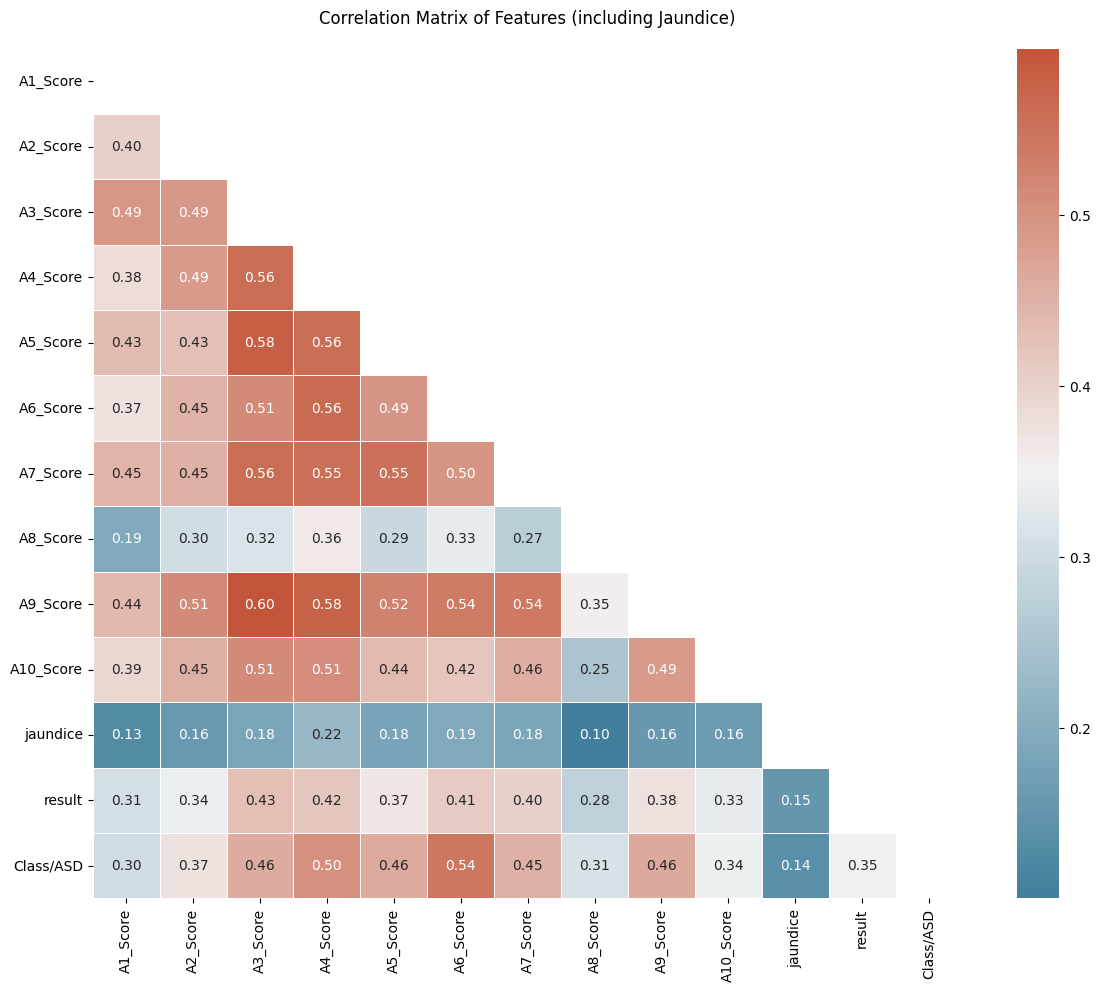

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_bar(ax, df, column_name, hue_column='Class/ASD', top_n=15, figsize=None):
    """
    Stacked bar plot for categorical column frequencies by target variable.
    Improved for better readability with adjusted title padding.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Get top categories
    top_categories = df[column_name].value_counts(dropna=False).nlargest(top_n).index
    
    # Create a crosstab (contingency table) for the column and class
    crosstab = pd.crosstab(
        df[column_name], 
        df[hue_column],
        dropna=False
    ).loc[top_categories]
    
    # Rename the columns to be more descriptive
    crosstab.columns = ['Non-ASD', 'ASD']
    
    # Replace NaN index with 'NaN' string if it exists
    if any(pd.isna(idx) for idx in crosstab.index):
        crosstab.index = [str(idx) if not pd.isna(idx) else 'NaN' for idx in crosstab.index]
    
    # Create stacked bar chart
    crosstab.plot(kind='bar', stacked=True, ax=ax)
    
    if len(top_categories) > top_n:
        title = f'Top {top_n} for {column_name} by ASD Classification'
    else:
        title = f'Frequency of {column_name} by ASD Classification'
        
    # Set title with more padding to avoid overlap
    ax.set_title(title, pad=15)
    ax.set_xlabel(column_name, labelpad=10)  # Add more padding to xlabel
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Improve text visibility on bars
    for i, (_, row) in enumerate(crosstab.iterrows()):
        non_asd_count = row['Non-ASD']
        asd_count = row['ASD']
        total = non_asd_count + asd_count
        
        # Always show the ASD count at the top of each bar
        ax.text(i, non_asd_count + asd_count/2, f"{int(asd_count)}", 
                ha='center', va='center', color='black', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Add the Non-ASD count if it's large enough
        if non_asd_count > total * 0.08:
            ax.text(i, non_asd_count/2, f"{int(non_asd_count)}", 
                    ha='center', va='center', color='white', fontweight='bold')
        
        # Show Non-ASD count with contrasting background if enough space
        if non_asd_count >= 20:
            ax.text(i, non_asd_count/2, f"{int(non_asd_count)}", 
                    ha='center', va='center', color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue', 
                          boxstyle='round,pad=0.2'))


def plot_ethnicity_bar(ax, df, column_name, hue_column='Class/ASD', top_n=8, figsize=None):
    """
    Special case of plot_categorical_bar for ethnicity column.
    Uses the same logic but with specialized formatting for ethnicity data.
    """
    # Use the same implementation as plot_categorical_bar
    plot_categorical_bar(ax, df, column_name, hue_column, top_n, figsize)
    
    # Override title specifically for ethnicity
    ax.set_title(f'Top {top_n} Ethnicities by ASD Classification', pad=15)


def plot_positive_frequency_scores(ax, df, score_columns, hue_column='Class/ASD'):
    """
    Side-by-side bar plot showing positive response percentages for binary score columns by target.
    Improved readability with clearer text and better title placement.
    """
    plot_data = {}
    
    for col in score_columns:
        if col in df.columns and df[col].dropna().isin([0, 1]).all():
            # Count positives for each class
            pos_asd = df[df[hue_column] == 1][col].sum()
            pos_non_asd = df[df[hue_column] == 0][col].sum()
            
            # Count totals for each class
            total_asd = len(df[df[hue_column] == 1])
            total_non_asd = len(df[df[hue_column] == 0])
            
            # Store the counts
            plot_data[col] = {
                'ASD': pos_asd, 
                'Non-ASD': pos_non_asd,
                'Total-ASD': total_asd,
                'Total-Non-ASD': total_non_asd
            }
    
    if not plot_data:
        ax.set_visible(False)
        return
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(plot_data).T
    
    # Calculate percentages
    plot_df['ASD-pct'] = (plot_df['ASD'] / plot_df['Total-ASD']) * 100
    plot_df['Non-ASD-pct'] = (plot_df['Non-ASD'] / plot_df['Total-Non-ASD']) * 100
    
    # Create GROUPED bar chart instead of stacked
    plot_df_display = plot_df[['Non-ASD-pct', 'ASD-pct']].rename(
        columns={'Non-ASD-pct': 'Non-ASD', 'ASD-pct': 'ASD'}
    )
    
    # Plot as grouped bars
    plot_df_display.plot(kind='bar', ax=ax)
    
    # Set title with much more padding to avoid overlap with other plots
    ax.set_title('Positive Response Rates by ASD Classification (A1-A10)', pad=20)
    ax.set_xlabel('Questionnaire Item', labelpad=10)  # More padding for x-label
    ax.set_ylabel('Positive Response Rate (%)')
    ax.set_ylim(0, 105)  # Increase y-limit slightly to make room for percentage labels
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Add percentages as text with better visibility
    for i, col in enumerate(plot_df_display.index):
        for j, cls in enumerate(['Non-ASD', 'ASD']):
            pct = plot_df_display.loc[col, cls]
            if pct > 2:  # Show more values
                ax.text(i-0.15+j*0.3, pct+2, f"{pct:.0f}%", 
                        ha='center', fontsize=9, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))


def plot_continuous_hist(ax, df, column_name, hue_column='Class/ASD', bins=20, max_age=None):
    """
    Stacked bar histogram for a continuous column with stacking by target variable.
    Improved to show ASD counts more clearly and adjusted title placement.
    Fixed age bin labels to properly show age ranges.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    data = df[column_name].dropna()
    
    if column_name == 'result':
        # For 'result' column, use custom bins that cover the full range
        min_val = max(0, data.min())  # Ensure minimum is not negative
        max_val = data.max()
        
        # Create bins that ensure we cover all values
        if max_val <= 15:
            bin_edges = np.linspace(min_val, max_val + 1, bins+1)
        else:
            # Use groups of 2 (0-1, 2-3, 4-5, etc.)
            bin_edges = np.arange(min_val, max_val + 2, 2)
    elif column_name == 'age':
        # Explicitly define age bins for better readability
        # These are fixed bins that make sense for age data
        age_bins = [0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
        
        # Get min and max values
        min_val = max(0, data.min())
        max_val = data.max()
        
        # Create appropriate bin edges
        bin_edges = [b for b in age_bins if b >= min_val - 1 and b <= max_val + 1]
        
        # Ensure we have at least 2 bin edges
        if len(bin_edges) < 2:
            bin_edges = np.linspace(min_val, max_val, bins+1)
        
        # Add the max value if it's not already included
        if bin_edges[-1] < max_val:
            bin_edges.append(max_val + 1)
    else:
        # For other columns, use regular binning
        min_val = data.min()
        
        if max_age is not None:
            max_val = max_age
        else:
            max_val = data.max()
        
        bin_edges = np.linspace(min_val, max_val, bins+1)
    
    # Fix for monotonically increasing bins
    bin_edges = np.sort(np.unique(bin_edges))
    
    # Get histograms for each class
    counts_non_asd = np.histogram(df[df[hue_column] == 0][column_name].dropna(), bins=bin_edges)[0]
    counts_asd = np.histogram(df[df[hue_column] == 1][column_name].dropna(), bins=bin_edges)[0]
    
    # Create bin labels with the correct formatting
    if column_name == 'result':
        bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])-1}" for i in range(len(bin_edges)-1)]
    elif column_name == 'age':
        # Use proper integer labels for age bins
        bin_labels = []
        for i in range(len(bin_edges)-1):
            # Use integers for age labels (no decimals)
            start_age = int(bin_edges[i])
            end_age = int(bin_edges[i+1]) - 1
            # Handle the case where the bin only contains one age
            if start_age == end_age:
                bin_labels.append(f"{start_age}")
            else:
                bin_labels.append(f"{start_age}-{end_age}")
    else:
        bin_labels = [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
    
    # Create DataFrame for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plot_df = pd.DataFrame({
        'Bin': bin_labels,
        'Non-ASD': counts_non_asd,
        'ASD': counts_asd,
        'Center': bin_centers
    })
    
    # Sort by bin center
    plot_df = plot_df.sort_values('Center')
    
    # Plot stacked bar histogram
    plot_df[['Non-ASD', 'ASD']].plot(
        kind='bar', stacked=True, ax=ax, width=0.85, rot=45
    )
    
    # Set title with more padding to avoid overlap
    ax.set_title(f'Distribution of {column_name} by ASD Classification', pad=15)
    ax.set_xlabel(column_name, labelpad=10)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    
    # Add counts as text on the ASD segments
    for i, (_, row) in enumerate(plot_df.iterrows()):
        non_asd_count = row['Non-ASD']
        asd_count = row['ASD']
        
        # Add ASD count if it's non-zero
        if asd_count > 0:
            ax.text(i, non_asd_count + asd_count/2, f"{int(asd_count)}", 
                    ha='center', va='center', color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))


def plot_continuous_boxplot(ax, df, column_name, hue_column='Class/ASD'):
    """
    Box plot for a continuous column, grouped by target variable.
    Enhanced to show more stats and adjusted title placement.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Create plot data
    plot_data = []
    
    for i, row in df.iterrows():
        class_val = row[hue_column]
        value = row[column_name]
        if not pd.isna(value):
            plot_data.append({
                'Value': value,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot boxplot with hue
    sns.boxplot(x='Class', y='Value', data=plot_df, ax=ax)
    
    # Calculate statistics
    non_asd_stats = {
        'mean': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].mean(),
        'median': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].median(),
        'std': plot_df[plot_df['Class'] == 'Non-ASD']['Value'].std(),
    }
    
    asd_stats = {
        'mean': plot_df[plot_df['Class'] == 'ASD']['Value'].mean(),
        'median': plot_df[plot_df['Class'] == 'ASD']['Value'].median(),
        'std': plot_df[plot_df['Class'] == 'ASD']['Value'].std(),
    }
    
    # Add stat text directly on the plot (not using figtext which doesn't work well in subplots)
    # Calculate positions - use the actual plot area
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    
    # Place stats text on the plot for Non-ASD (left side)
    non_asd_text = f"Non-ASD\nMean: {non_asd_stats['mean']:.2f}\nMedian: {non_asd_stats['median']:.2f}\nStd: {non_asd_stats['std']:.2f}"
    ax.annotate(
        non_asd_text,
        xy=(0, y_range[0]), 
        xytext=(-0.4, y_range[0] - (y_range[1] - y_range[0]) * 0.15),  # Position below the plot
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue', boxstyle='round,pad=0.3')
    )
    
    # Place stats text on the plot for ASD (right side)
    asd_text = f"ASD\nMean: {asd_stats['mean']:.2f}\nMedian: {asd_stats['median']:.2f}\nStd: {asd_stats['std']:.2f}"
    ax.annotate(
        asd_text,
        xy=(1, y_range[0]),
        xytext=(1.4, y_range[0] - (y_range[1] - y_range[0]) * 0.15),  # Position below the plot
        ha='center', va='top', fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='orange', boxstyle='round,pad=0.3')
    )
    
    # Adjust title and labels with more padding
    ax.set_title(f'Box plot of {column_name} by ASD Classification', pad=15)
    ax.set_ylabel(column_name, labelpad=10)
    ax.set_xlabel('Class')
    ax.grid(axis='y', linestyle='--')
    
    # Make sure there's enough space at the bottom for the annotations
    bottom_margin = 0.3
    plt.subplots_adjust(bottom=bottom_margin)
    
    # Expand the y-axis to make room for annotations
    ax.set_ylim(bottom=y_range[0] - (y_range[1] - y_range[0]) * 0.2)


def plot_correlation_heatmap(df, figsize=(10, 8), include_cols=None, exclude_columns=None):
    """
    Heatmap of correlations between numerical features.
    Improved for better readability.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_corr = df.copy()
    
    # Convert categorical columns to numeric if they aren't already
    if 'jaundice' in df_corr.columns:
        # Convert jaundice to numeric (assuming yes=1, no=0)
        if df_corr['jaundice'].dtype == 'object':
            df_corr['jaundice'] = df_corr['jaundice'].map({'yes': 1, 'no': 0})
    
    # Filter columns
    if include_cols:
        df_corr = df_corr[include_cols]
    
    if exclude_columns:  # This matches your function call
        df_corr = df_corr.drop(columns=exclude_columns, errors='ignore')
    
    # Select only numeric columns
    numerical_features = df_corr.select_dtypes(include=['number'])
    
    # Calculate correlation matrix
    correlation_matrix = numerical_features.corr()
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(correlation_matrix))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Plot the heatmap with improved readability
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap=cmap, 
                mask=mask,
                fmt=".2f",
                annot_kws={"size": 10},
                linewidths=0.5)
    
    plt.title('Correlation Matrix of Features (including Jaundice)', y=1.02)
    plt.tight_layout()
    plt.show()


# --- Grid Plotting Utility with Improved Spacing ---

def plot_in_grid(plot_funcs, ncols=2, figsize=(18, 40)):
    """
    Plots a list of (func, args, kwargs) in a grid.
    Improved with larger default figure size and much better spacing.
    """
    n_plots = len(plot_funcs)
    nrows = int(np.ceil(n_plots / ncols))
    
    # Create figure with more height for better readability and much more spacing
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(figsize[0], figsize[1]), 
        gridspec_kw={'hspace': 1.0, 'wspace': 0.6}  # Significantly increased spacing
    )
    
    if n_plots == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()
    
    for i, (plot_func, args, kwargs) in enumerate(plot_funcs):
        if i < len(axes):
            plot_func(axes[i], *args, **kwargs)
            
            # Adjust title position to be higher
            if axes[i].get_title():
                axes[i].set_title(axes[i].get_title(), pad=30)  # Increased padding for titles
            
            # Special handling for boxplots - make sure there's enough vertical space for stats
            if plot_func.__name__ == 'plot_continuous_boxplot':
                axes[i].figure.subplots_adjust(bottom=0.25)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    # Remove tight_layout() and just use the manual adjustments
    # plt.tight_layout()  # REMOVE THIS LINE
    plt.subplots_adjust(top=0.97, bottom=0.05, hspace=1.0)
    
    plt.show()

# --- Example usage with modifications ---

# When creating your plot_funcs list, filter out the age distribution plot
# and create the updated list like this:

binary_score_columns = [f'A{i}_Score' for i in range(1, 11)]
categorical_columns = [
    'gender', 'jaundice', 'autism', 'used_app_before', 'ethnicity', 
    'age_desc', 'contry_of_res', 'relation'
]
continuous_columns = ['result']  # Removed 'age' from continuous columns for histogram

plot_funcs = []

# 1. Positive frequency bar (A1-A10)
plot_funcs.append(
    (plot_positive_frequency_scores, (train, binary_score_columns), {})
)

# 2. Categorical variables as bar charts
for col in categorical_columns:
    if col == 'contry_of_res':
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {'top_n': 15})
        )
    elif col == 'ethnicity':
        plot_funcs.append(
            (plot_ethnicity_bar, (train, col), {'top_n': 8})
        )
    else:
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {})
        )

# 3. Continuous variables - only include age for boxplot, not histogram
plot_funcs.append(
    (plot_continuous_boxplot, (train, 'age'), {})
)

# 4. Include both histogram and boxplot for result
plot_funcs.append(
    (plot_continuous_hist, (train, 'result'), {'bins': 15})
)
plot_funcs.append(
    (plot_continuous_boxplot, (train, 'result'), {})
)

# Plot everything in a grid with larger size and more vertical space for better readability
plot_in_grid(plot_funcs, ncols=2, figsize=(18, 40))  # Increased vertical size significantly

# Correlation heatmap (separate plot)
include_columns = binary_score_columns + ['jaundice', 'result', 'Class/ASD']
exclude_columns = ['age']

plot_correlation_heatmap(
    train, 
    figsize=(12, 10),
    include_cols=include_columns,
    exclude_columns=exclude_columns
)

**Notes**:
- The ratio of White-European to autistic is far greater than any of the other countries, based on the chart 'Top 8 Ethnicities by ASD classification'.
- We have a significant amount more males than females in both the ASD and non-ASD groups, with the gender imbalance particularly pronounced in the ASD group.
- There looks to be a correlation between jaundice and autism, though the sample size for jaundice is relatively small compared to the overall population studied.
- Based on the Correlation Matrix of Features, A3_Score, A4_Score and A9_Score, has the strongest coorelation compared to other variables.
- Based on the Correlation Matrix of Features, A8_Score has a weak correlation compared to other variables.

### Chi-square tests

In [13]:
#@title Chi-Square (χ²) Test of Independence with Enhanced Visualization
def create_contingency_table(df, var1, var2):
    return pd.crosstab(df[var1], df[var2], dropna=False)

def perform_chi_square_test(contingency_table):
    chi2, p_value, dof, expected = chi2_contingency(contingency_table, correction=True)
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    }

def analyze_categorical_variables(df, categorical_cols=None):
    if categorical_cols is None:
        categorical_cols = ['gender', 'ethnicity', 'jaundice', 'autism', 
                           'contry_of_res', 'used_app_before', 
                           'relation', 'Class/ASD']
    
    results = []
    
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            var1 = categorical_cols[i]
            var2 = categorical_cols[j]
            
            contingency_table = create_contingency_table(df, var1, var2)
            expected = chi2_contingency(contingency_table)[3]
            expected_less_than_5 = (expected < 5).sum()
            total_cells = expected.size
            
            test_result = perform_chi_square_test(contingency_table)
            
            results.append({
                'variable1': var1,
                'variable2': var2,
                'chi2_statistic': test_result['chi2_statistic'],
                'p_value': test_result['p_value'],
                'degrees_of_freedom': test_result['degrees_of_freedom'],
                'cells_expected_less_than_5': expected_less_than_5,
                'percent_cells_expected_less_than_5': (expected_less_than_5 / total_cells) * 100
            })
    
    return pd.DataFrame(results)

def print_chi_square_summary(results):
    df = results.copy().sort_values('p_value')

    df['significance'] = df['p_value'].apply(lambda p: 
        "Yes (***)" if p < 0.001 else 
        "Yes (**)" if p < 0.01 else 
        "Yes (*)" if p < 0.05 else "No")
    
    df['p_value_fmt'] = df['p_value'].apply(lambda p: "<0.0001" if p < 0.0001 else f"{p:.4f}")
    
    display_cols = ['variable1', 'variable2', 'chi2_statistic', 'p_value_fmt', 
                   'degrees_of_freedom', 'significance']
    display_df = df[display_cols]
    display_df.columns = ['Variable 1', 'Variable 2', 'Chi²', 'p-value', 'df', 'Significant']
    
    print("\n╔═════════════════════ Chi-Square Test Results ═════════════════════╗")
    print(display_df.to_string(index=False, formatters={'Chi²': '{:.2f}'.format}))
    
    sig_count = (df['p_value'] < 0.05).sum()
    total_count = len(df)
    percent = (sig_count / total_count) * 100
    
    print("\n  ───────────────────────────────────────────────────────────────")
    print(f"  Found {sig_count} significant relationships out of {total_count} tested ({percent:.1f}%)")
    print("\n╚═════════════════════════════════════════════════════════════════╝")
    print("\n  Significance levels: *** p<0.001, ** p<0.01, * p<0.05")

def run_chi_square_analysis(df, categorical_cols=None):
    print("Running Chi-Square tests on categorical variables...")
    results = analyze_categorical_variables(df, categorical_cols)
    print_chi_square_summary(results)
    return results

results = run_chi_square_analysis(train)

Running Chi-Square tests on categorical variables...

╔═════════════════════ Chi-Square Test Results ═════════════════════╗
     Variable 1      Variable 2   Chi² p-value  df Significant
  contry_of_res        relation 663.45 <0.0001 275   Yes (***)
      ethnicity       Class/ASD 181.02 <0.0001  11   Yes (***)
         autism       Class/ASD 100.82 <0.0001   1   Yes (***)
  contry_of_res       Class/ASD 205.75 <0.0001  55   Yes (***)
      ethnicity          autism  98.23 <0.0001  11   Yes (***)
         autism   contry_of_res 149.74 <0.0001  55   Yes (***)
      ethnicity        relation 114.11 <0.0001  55   Yes (***)
      ethnicity        jaundice  37.17  0.0001  11   Yes (***)
       jaundice       Class/ASD  14.60  0.0001   1   Yes (***)
       jaundice          autism   8.96  0.0028   1    Yes (**)
  contry_of_res used_app_before  88.17  0.0030  55    Yes (**)
       relation       Class/ASD  10.56  0.0608   5          No
         autism        relation  10.52  0.0618   5       

**Notes**:
- Jaundice and Class/ASD: There's a statistically significant association. This strong significance level indicates that having a history of jaundice is not independent from autism classification in this dataset.
- Jaundice and autism: There's also a significant association. This is still significant but at a slightly lower level (p < 0.01).

## Mann-Whitney U Test

Mann-Whitney U test results:
U statistic: 59584.00
p-value: 0.0019


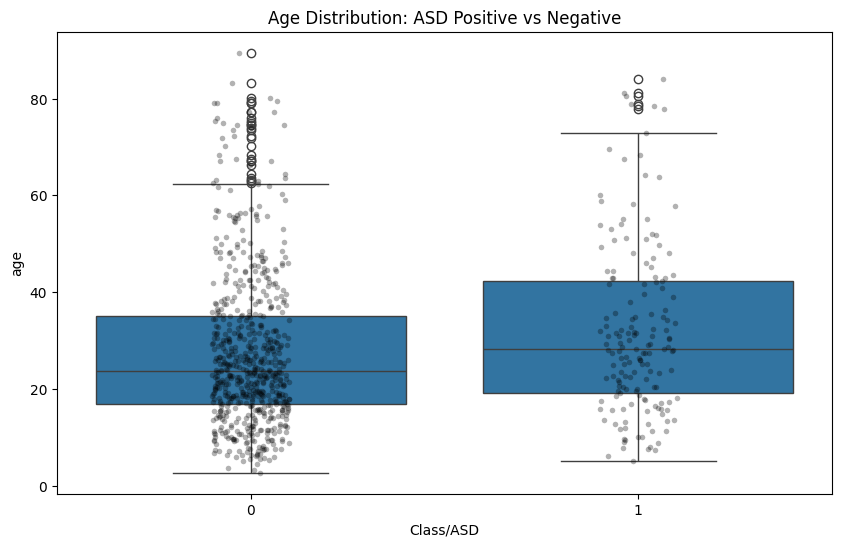

In [14]:
#@title Mann-Whiteney U Test
def perform_mann_whitney_test(data, group_column, value_column, group1, group2):
    """
    Perform Mann-Whitney U test between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    
    Returns:
    --------
    tuple
        (U statistic, p-value)
    """
    # Extract values for each group
    group1_values = data[data[group_column] == group1][value_column]
    group2_values = data[data[group_column] == group2][value_column]
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(
        group1_values, 
        group2_values, 
        alternative='two-sided'
    )
    
    return statistic, p_value

def plot_group_comparison(data, group_column, value_column, group1, group2, title=None):
    """
    Create a box plot comparing the distribution of values between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    sns.boxplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])])
    
    # Add individual points
    sns.stripplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])],
                 color='black', alpha=0.3, size=4)
    
    if title:
        plt.title(title)
    plt.show()
    
# Example: Compare age distribution between ASD positive and negative groups
statistic, p_value = perform_mann_whitney_test(
    train, 
    'Class/ASD', 
    'age',
    1,  # ASD positive
    0   # ASD negative
)

print(f"Mann-Whitney U test results:")
print(f"U statistic: {statistic:.2f}")
print(f"p-value: {p_value:.4f}")

# Create visualization
plot_group_comparison(
    train,
    'Class/ASD',
    'age',
    1,
    0,
    title='Age Distribution: ASD Positive vs Negative'
) 

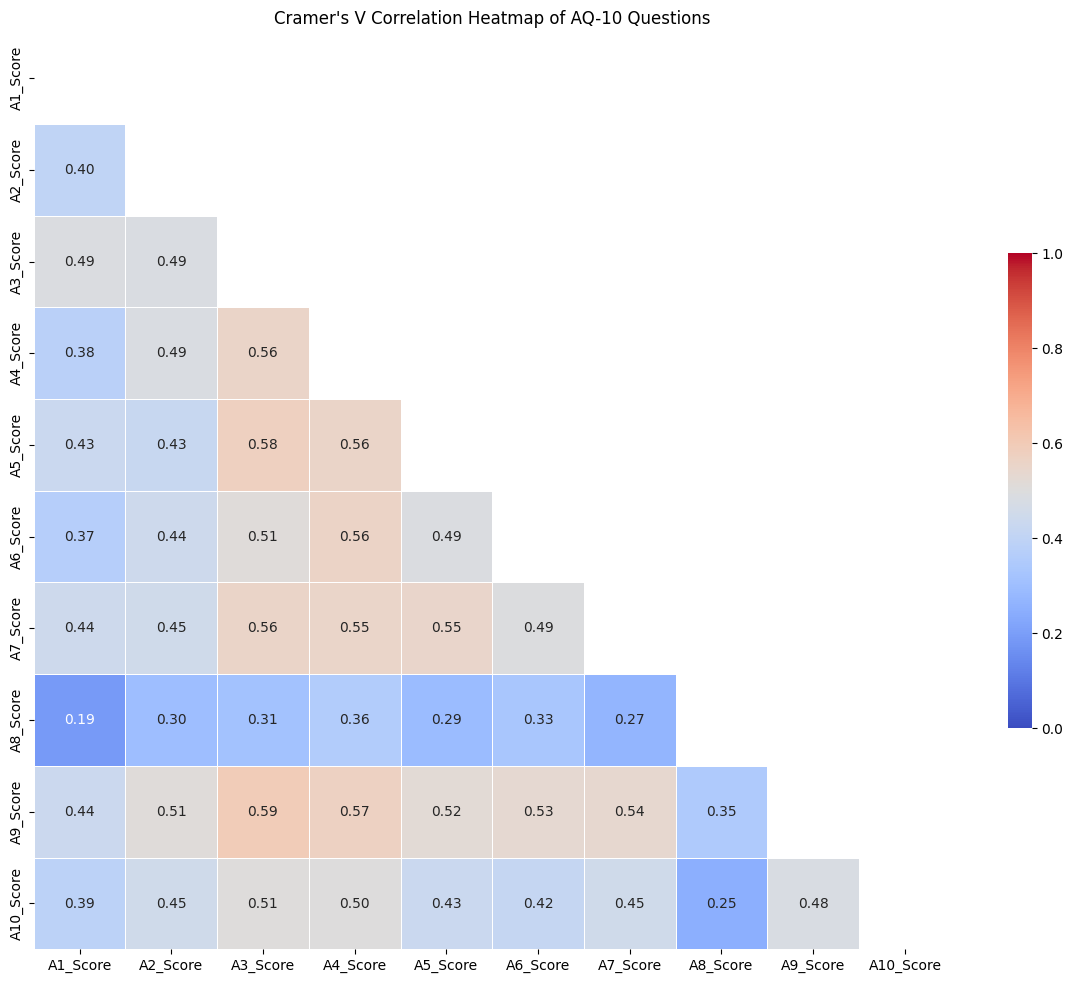


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.595
A3_Score - A5_Score: 0.577
A4_Score - A9_Score: 0.574
A4_Score - A6_Score: 0.561
A4_Score - A5_Score: 0.557


In [15]:
#@title Cramér’s V
def cramers_v(confusion_matrix):
    """
    Calculate Cramer's V statistic for categorical-categorical association.
    
    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        The confusion matrix (contingency table)
    
    Returns:
    --------
    float
        Cramer's V statistic
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))

def calculate_cramers_v_matrix(data, columns):
    """
    Calculate Cramer's V for all pairs of categorical variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of Cramer's V values
    """
    n_cols = len(columns)
    cramers_v_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                cramers_v_matrix[i, j] = 1.0
            else:
                confusion_matrix = pd.crosstab(data[columns[i]], data[columns[j]])
                cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
    
    return pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)

def plot_correlation_heatmap(correlation_matrix, title="Cramer's V Correlation Heatmap"):
    """
    Create a heatmap visualization of the correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=0,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate Cramer's V matrix
cramers_v_matrix = calculate_cramers_v_matrix(train, aq_columns)

# Plot correlation heatmap
plot_correlation_heatmap(
    cramers_v_matrix,
    title="Cramer's V Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))
# Stack and sort
correlations = upper_triangle.stack().sort_values(ascending=False)
for (q1, q2), corr in correlations.head().items():
    print(f"{q1} - {q2}: {corr:.3f}") 

**Notes**:
- A3_Score and A4_Score continue to show stronger associations with other questions (0.5-0.6 range)
- A8_Score shows the weakest associations across the board (mostly 0.19-0.36)
- The strongest association is between A3 and A9 (0.59)

## Polychoric Correlation

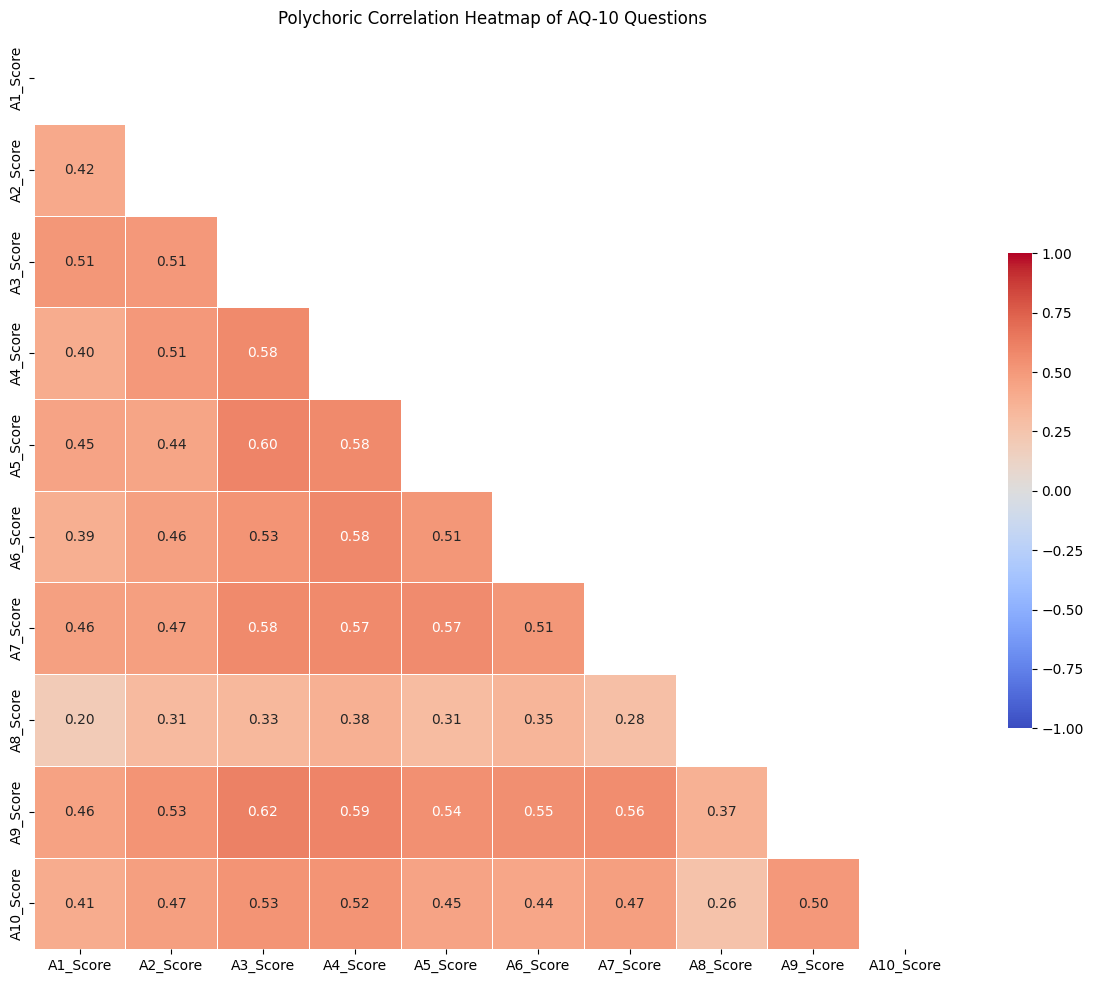


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.615
A3_Score - A5_Score: 0.598
A4_Score - A9_Score: 0.595
A4_Score - A6_Score: 0.582
A4_Score - A5_Score: 0.578


In [16]:
#@title Polychoric correlation
def polychoric_approx(x, y):
    """
    Calculate an approximation of polychoric correlation
    using Pearson correlation with a correction factor.
    
    Parameters:
    -----------
    x : pandas.Series
        First ordinal variable
    y : pandas.Series
        Second ordinal variable
        
    Returns:
    --------
    float
        Approximate polychoric correlation coefficient
    """
    # Handle missing values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Use Spearman correlation as starting point
    rho_spearman, _ = stats.spearmanr(x_clean, y_clean)
    
    # Apply correction to approximate polychoric correlation
    # This uses a common rule of thumb for converting Spearman to polychoric
    rho_polychoric = 2 * np.sin(np.pi * rho_spearman / 6)
    
    return rho_polychoric

def calculate_polychoric_matrix(data, columns):
    """
    Calculate polychoric correlation for all pairs of ordinal variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of polychoric correlation values
    """
    n_cols = len(columns)
    polychoric_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                polychoric_matrix[i, j] = 1.0
            else:
                polychoric_matrix[i, j] = polychoric_approx(data[columns[i]], data[columns[j]])
    
    return pd.DataFrame(polychoric_matrix, index=columns, columns=columns)

def plot_polychoric_heatmap(correlation_matrix, title="Polychoric Correlation Heatmap"):
    """
    Create a heatmap visualization of the polychoric correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate polychoric correlation matrix
polychoric_matrix = calculate_polychoric_matrix(train, aq_columns)

# Plot correlation heatmap
plot_polychoric_heatmap(
    polychoric_matrix, 
    title="Polychoric Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = polychoric_matrix.where(np.triu(np.ones(polychoric_matrix.shape), k=1).astype(bool))
# Take absolute values for the strongest correlations (positive or negative)
abs_correlations = upper_triangle.abs().stack().sort_values(ascending=False)
for (q1, q2), corr in abs_correlations.head().items():
    actual_corr = upper_triangle.loc[q1, q2]
    print(f"{q1} - {q2}: {actual_corr:.3f}")

**Notes**:
- Most correlations are moderate (0.4-0.6), indicating the questions are measuring related but distinct aspects of autism traits.
- A8_Score shows the weakest correlations with other questions (mostly 0.2-0.3).
- A3, A4, A5, and A9 scores show stronger correlations with multiple other questions.
- The strongest correlation appears to be between A3 and A9 (0.62).

# Phase 2: Supervised Learning Benchmarks

## Setup

### Data Preprocessing


In [17]:
# Display the shape of the training data
print(train.shape)
print(train.head())

# Create country_label mapping based on the ratio of positive to negative cases
country_label = (train[train['Class/ASD'] == 1]['contry_of_res'].value_counts() / 
                train[train['Class/ASD'] == 0]['contry_of_res'].value_counts() * 
                train['contry_of_res'].value_counts()).sort_values(ascending=False)
country_label = country_label.map(lambda x: 0 if np.isnan(x) else x)
# Normalize to [0,1] range
country_label = dict((country_label - min(country_label))/(max(country_label) - min(country_label)))

# Add default values for countries that might be missing
for item in ['Uruguay', 'Lebanon', 'Philippines']:
    country_label[item] = 0

# Create ethnicity mapping
eth_label = train.loc[:, ['ethnicity', 'Class/ASD']]
# Map similar categories
mapper = {
    'Others': 'Unknown'
}
eth_label['ethnicity'] = eth_label['ethnicity'].map(lambda x: mapper[x] if x in mapper else x)
# Calculate ratio similar to country mapping
eth_label = (eth_label[eth_label['Class/ASD'] == 1]['ethnicity'].value_counts() / 
            eth_label[eth_label['Class/ASD'] == 0]['ethnicity'].value_counts() * 
            eth_label['ethnicity'].value_counts()).sort_values(ascending=False)
eth_label = eth_label.map(lambda x: 0 if np.isnan(x) else x)
# Normalize to [0,1] range
eth_label = dict((eth_label - min(eth_label))/(max(eth_label) - min(eth_label)))

# Define preprocessing function
def preprocess(data):
    data_temp = data.copy()
    
    # Drop columns
    data_temp = data_temp.drop(['relation', 'used_app_before'], axis=1)
    
    # Encode binary categorical variables
    data_temp['gender'] = data_temp['gender'].map(lambda x: 1 if x == 'm' else 0)
    data_temp['jaundice'] = data_temp['jaundice'].map(lambda x: 1 if x == 'yes' else 0)
    data_temp['autism'] = data_temp['autism'].map(lambda x: 1 if x == 'yes' else 0)
    
    # Encode ethnicity using the mapping
    data_temp['ethnicity'] = data_temp['ethnicity'].map(lambda x: 'others' if (x == 'Others' or x == '?') else x)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(eth_label)
    
    # Encode country using the mapping
    data_temp['contry_of_res'] = data_temp['contry_of_res'].map(country_label)
    
    # Normalize numerical features
    data_temp['age'] = (data_temp['age'] - min(data_temp['age']))/(max(data_temp['age']) - min(data_temp['age']))
    data_temp['result'] = (data_temp['result'] - min(data_temp['result']))/(max(data_temp['result']) - min(data_temp['result']))
    
    return data_temp

# Apply preprocessing
preprocessed_train = preprocess(train)

print(preprocessed_train.head())


# Set random seed
SEED = 16
np.random.seed(SEED)

# Separate features (X) and target (y)
X = preprocessed_train.drop('Class/ASD', axis=1)
y = preprocessed_train['Class/ASD']

# Split data for visualization purposes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Calculate the ratio of negative to positive samples
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# 3x stratified 10 fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

# faster cv for optuna
cv_quick = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


# Display shapes of data
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", list(X.columns))


(800, 20)
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         0         1         0         1         0         1   
1         0         0         0         0         0         0         0   
2         1         1         1         1         1         1         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score        age gender       ethnicity jaundice  \
0         0         1          1  38.172746      f         Unknown       no   
1         0         0          0  47.750517      m         Unknown       no   
2         1         1          1   7.380373      m  White-European       no   
3         0         0          0  23.561927      f         Unknown       no   
4         0         0          0  43.205790      m         Unknown       no   

  autism  contry_of_res used_app_before     result relation  Cla

**Explanation:**

This code snippet performs crucial data preprocessing steps to prepare the autism dataset for machine learning. Here's a breakdown:

1.  **Initial Data Inspection:**
    -   The code starts by displaying the shape (number of rows and columns) and the first few rows of the training dataset (`train.shape` and `train.head()`). This provides an initial overview of the data.

2.  **Country Encoding:**
    -   **Purpose:** The goal is to convert the categorical 'contry\_of\_res' (country of residence) feature into numerical data suitable for machine learning models.  It encodes each country based on the ratio of positive (autism spectrum disorder (ASD) present) to negative (ASD absent) cases. This captures how indicative a country is of ASD.
    -   **Calculation:** For each country, the code calculates the ratio of individuals with ASD to those without ASD, multiplied by the country's frequency in the dataset.  This results in a weighted representation of each country's association with ASD.
    -   **Normalization:** The calculated ratios are then normalized to a range between 0 and 1 using min-max scaling.  This ensures all values are within a consistent range.  The result is stored in the `country_label` dictionary.
    -   **Handling Missing Countries:** To account for countries that might appear in the test set but not in the training set (e.g., 'Uruguay', 'Lebanon', 'Philippines'), default values of 0 are assigned to these countries in the `country_label` dictionary.

3.  **Ethnicity Encoding:**
    -   **Purpose:** Similar to country encoding, this converts the categorical 'ethnicity' feature into numerical data, reflecting the association between ethnicity and ASD.
    -   **Mapping Similar Categories:** The code maps the 'Others' category to 'Unknown' to consolidate similar groups.
    -   **Ratio Calculation and Normalization:** The code calculates the ratio of positive to negative cases for each ethnicity, normalizes these ratios to a \[0, 1] range using min-max scaling, and stores the results in the `eth_label` dictionary.

4.  **Preprocessing Function (`preprocess`):**
    -   **Purpose:** This function encapsulates all the preprocessing steps and applies them to the dataset.
    -   **Dropping Columns:** Irrelevant features like 'relation' and 'used\_app\_before' are dropped.
    -   **Binary Encoding:** Binary categorical features ('gender', 'jaundice', 'autism') are converted to numerical (0 and 1) format.
    -   **Ethnicity and Country Mapping:** The pre-calculated `eth_label` and `country_label` dictionaries are used to map the respective categorical features to numerical values.  The ethnicity mapping also handles cases where the ethnicity is 'Others' or '?'.
    -   **Numerical Feature Normalization:** The numerical features 'age' and 'result' are normalized using min-max scaling to the \[0, 1] range.

5.  **Applying Preprocessing and Data Splitting:**
    -   The `preprocess` function is applied to the training data (`train`) to create the `preprocessed_train` DataFrame.
    -   The preprocessed data is then split into features \( (X) \) and target \( (y) \) variables.  The target variable is 'Class/ASD'.
    -   The data is further split into training and testing sets (`X_train`, `X_test`, `y_train`, `y_test`) using `train_test_split`.  Stratified splitting is used to maintain the same class distribution in both sets, and a random seed (SEED = 16) ensures reproducibility.

6.  **Handling Class Imbalance**
    -   The code calculates the ratio of negative to positive samples in the training set.  This information can be used to address class imbalance issues during model training (e.g., by weighting the classes).

7.  **Cross-Validation Setup:**
    -   Cross-validation strategies are defined: `RepeatedStratifiedKFold` for robust model evaluation and `StratifiedKFold` for faster hyperparameter tuning with Optuna. Both methods ensure each fold maintains the original class distribution of the data.

8.  **Data Shape Display:**
    -   Finally, the shapes of the feature matrix \( (X) \) and target vector \( (y) \) are printed, along with the column names of \( X \), for verification.


### Helper Functions
Hyperparam objectives and graph functions

In [18]:
# graph helpers, collapse me
def plot_confusion_matrix(model, X_test, y_test, ax=None, title="Normalized Confusion Matrix"):
    """Plot a confusion matrix for the model predictions."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(title, fontsize=14)
    return ax

def plot_roc_curve(model, X_test, y_test, ax=None, title="ROC Curve"):
    """Plot the ROC curve for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="lower right")
    return ax

def plot_precision_recall_curve(model, X_test, y_test, ax=None, title="Precision-Recall Curve"):
    """Plot the precision-recall curve for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)
    
    ax.plot(recall, precision, color='blue', lw=2,
            label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc="best")
    return ax

def plot_permutation_importance(model, X_test, y_test, ax=None, title="Permutation Feature Importance", random_state=42):
    """Plot permutation feature importance for the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=-1
    )
    
    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()
    
    # Plot
    ax.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=X_test.columns[sorted_idx]
    )
    ax.set_title(title, fontsize=14)
    return ax

def print_cv_results(cv_results, scoring_dict, model_name="Model"):
    """Print cross-validation results in a formatted way."""
    print(f"{model_name.upper()} RESULTS:")
    for metric in scoring_dict.keys():
        scores = cv_results[f'test_{metric}']
        print(f"{metric.upper()}:")
        print(f"  Mean: {np.mean(scores):.4f}")
        print(f"  Std Dev: {np.std(scores):.4f}")
        print(f"  Min: {np.min(scores):.4f}")
        print(f"  Max: {np.max(scores):.4f}")

def create_model_dashboard(model, X_test, y_test, cv_results, scoring_dict, model_name="Model"):
    """Create a comprehensive dashboard of model performance."""
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Plot each visualization
    plot_confusion_matrix(model, X_test, y_test, ax=axes[0, 0])
    plot_roc_curve(model, X_test, y_test, ax=axes[0, 1])
    plot_precision_recall_curve(model, X_test, y_test, ax=axes[1, 0])
    plot_permutation_importance(model, X_test, y_test, ax=axes[1, 1])
    
    # Add a title to the entire figure
    fig.suptitle(f"{model_name} Performance Dashboard", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    
    # Print CV results
    print_cv_results(cv_results, scoring_dict, model_name)
    
    plt.show()

In [19]:
# Define hyperparam objectives, collapse me
def lr_objective(trial):
    # Define hyperparameters to tune
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    C = trial.suggest_float("C", 1e-3, 10, log=True)
    
    # Conditional hyperparameters
    params = {
        "penalty": penalty,
        "solver": "saga",
        "C": C,
        "max_iter": 5000,
        "class_weight": "balanced",
        "random_state": SEED
    }
    
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
    
    # Create pipeline with the suggested hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**params))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=cv, 
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    return scores.mean()

def catboost_objective(trial):
    # Define hyperparameters to tune
    iterations = trial.suggest_int('iterations', 100, 2000)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True)
    border_count = trial.suggest_int('border_count', 32, 255)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 1)
    random_strength = trial.suggest_float('random_strength', 1e-9, 10, log=True)
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    
    # Class weights for imbalance
    class_weights = [1, len(y[y==0])/len(y[y==1])]  # Balanced weights
    
    # Create parameter dict
    params = {
        'iterations': iterations,
        'learning_rate': learning_rate,
        'depth': depth,
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': border_count,
        'bagging_temperature': bagging_temperature,
        'random_strength': random_strength,
        'grow_policy': grow_policy,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'class_weights': class_weights,
        'random_seed': SEED,
        'verbose': False
    }
    
    # Conditional parameters based on grow policy
    if grow_policy == 'Lossguide':
        params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 50)
    
    # Create pipeline with the suggested hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', CatBoostClassifier(**params))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=cv_quick, 
        scoring="balanced_accuracy",
        n_jobs=1  # CatBoost handles parallelism internally
    )
    
    return scores.mean()

def rf_objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    # Create pipeline with the suggested hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        ))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=cv, 
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    return scores.mean()

def xgb_objective(trial):
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        # For log scale parameters, use a small positive number instead of 0
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'scale_pos_weight': neg_pos_ratio,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': SEED,
        'n_jobs': -1  # Use all cores
    }
    
    # Create pipeline with the suggested hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(**params))
    ])
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=cv, 
        scoring="balanced_accuracy",
        n_jobs=-1
    )
    
    return scores.mean()



## Testing Standard Models
**General testing process:**
1. Pipeline Creation: We create a processing pipeline for each model. This pipeline:
    - Handles data preprocessing steps (scaling, encoding, etc.)
    - Applies the machine learning algorithm
    - Ensures consistent processing between training and testing phases
2. Initial Visualization: We fit the pipeline to a regular train-test split first. This gives us clean visualizations without the complexity of cross-validation, making it easier to understand the model's basic performance.
    - **Confusion Matrix (Normalized):**  
      This matrix shows how well the model distinguishes between classes. Each cell displays the proportion of true and false predictions for each category after normalization, giving insight into both overall accuracy and possible class-specific weaknesses (e.g., does the model miss more positives or negatives?). This is essential for imbalanced datasets, where measuring only global accuracy can be misleading.
      
    - **ROC Curve (Receiver Operating Characteristic):**  
      The ROC curve plots the True Positive Rate against the False Positive Rate at various thresholds. The area under this curve (ROC-AUC) summarizes how well the model can separate the two classes across all possible cutoff points. A higher curve means the model is generally making better distinction between classes. We use this because it's robust to imbalance and widely used for binary problems.
      
    - **Precision-Recall Curve:**  
      This curve shows how precision and recall trade off as we vary the classification threshold. For imbalanced datasets, the precision-recall curve is often more informative than the ROC curve, as it focuses on the minority class and how accurately those rare positives are being identified. The area under this curve (AP, or average precision) gives an overall measure of effectiveness in identifying the positive class.
      
    - **Permutation Feature Importance:**  
      This plot shows which features the model relies on most for its predictions. It is computed by randomly shuffling each feature and measuring how much that affects model accuracy. Features whose shuffling causes large drops in performance are more important. Visualizing feature importance helps us interpret the model and connect its behavior to domain knowledge.
3. We score the model on the metrics balanced accuracy, ROC-AUC, PR-AUC, F1, and MCC
4. Hyperparameter Optimization
    - First we run the models with standard parameters to establish a baseline
    - Then we use Optuna (an automated hyperparamater optimization framework) to find the best possible configuration for each model
5. During metric scoring, we use 3x repeated stratified 10-fold cross validation, which ensures that:
    - Stratification: Each fold maintains the same proportion of target classes as the full dataset.
    - Multiple Repeats: We run the entire 10-fold cross-validation process three times with different random splits.
    - 10 Folds: We divide the data into 10 equal parts (folds). The model trains on 9 parts and tests on the remaining part, rotating through all possible combinations.

**Why it matters:**
- Preventing overfitting: We want to ensure that our models work well on new data, not just what they were trained on. Cross validation forces the model to prove itself on multiple subsets, giving us more confidence that it's learning meaningful patterns instead of just memorizing the training data.
- Handling imbalanced data: Our target variable is imbalanced, and our approach with stratification and varied metrics addresses this.
- Reliable performance estimates: With repeated cross validation, we get more stable estimates of model performance, rather than single point estimates.


### Logistic Regression

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


BASELINE LOGISTIC REGRESSION WITH ELASTIC NET RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8373
  Std Dev: 0.0482
  Min: 0.7109
  Max: 0.9141
ROC_AUC:
  Mean: 0.9095
  Std Dev: 0.0343
  Min: 0.8301
  Max: 0.9629
PR_AUC:
  Mean: 0.7241
  Std Dev: 0.0894
  Min: 0.5755
  Max: 0.9012
F1:
  Mean: 0.6626
  Std Dev: 0.0652
  Min: 0.5128
  Max: 0.7895
MCC:
  Mean: 0.5809
  Std Dev: 0.0866
  Min: 0.3728
  Max: 0.7419


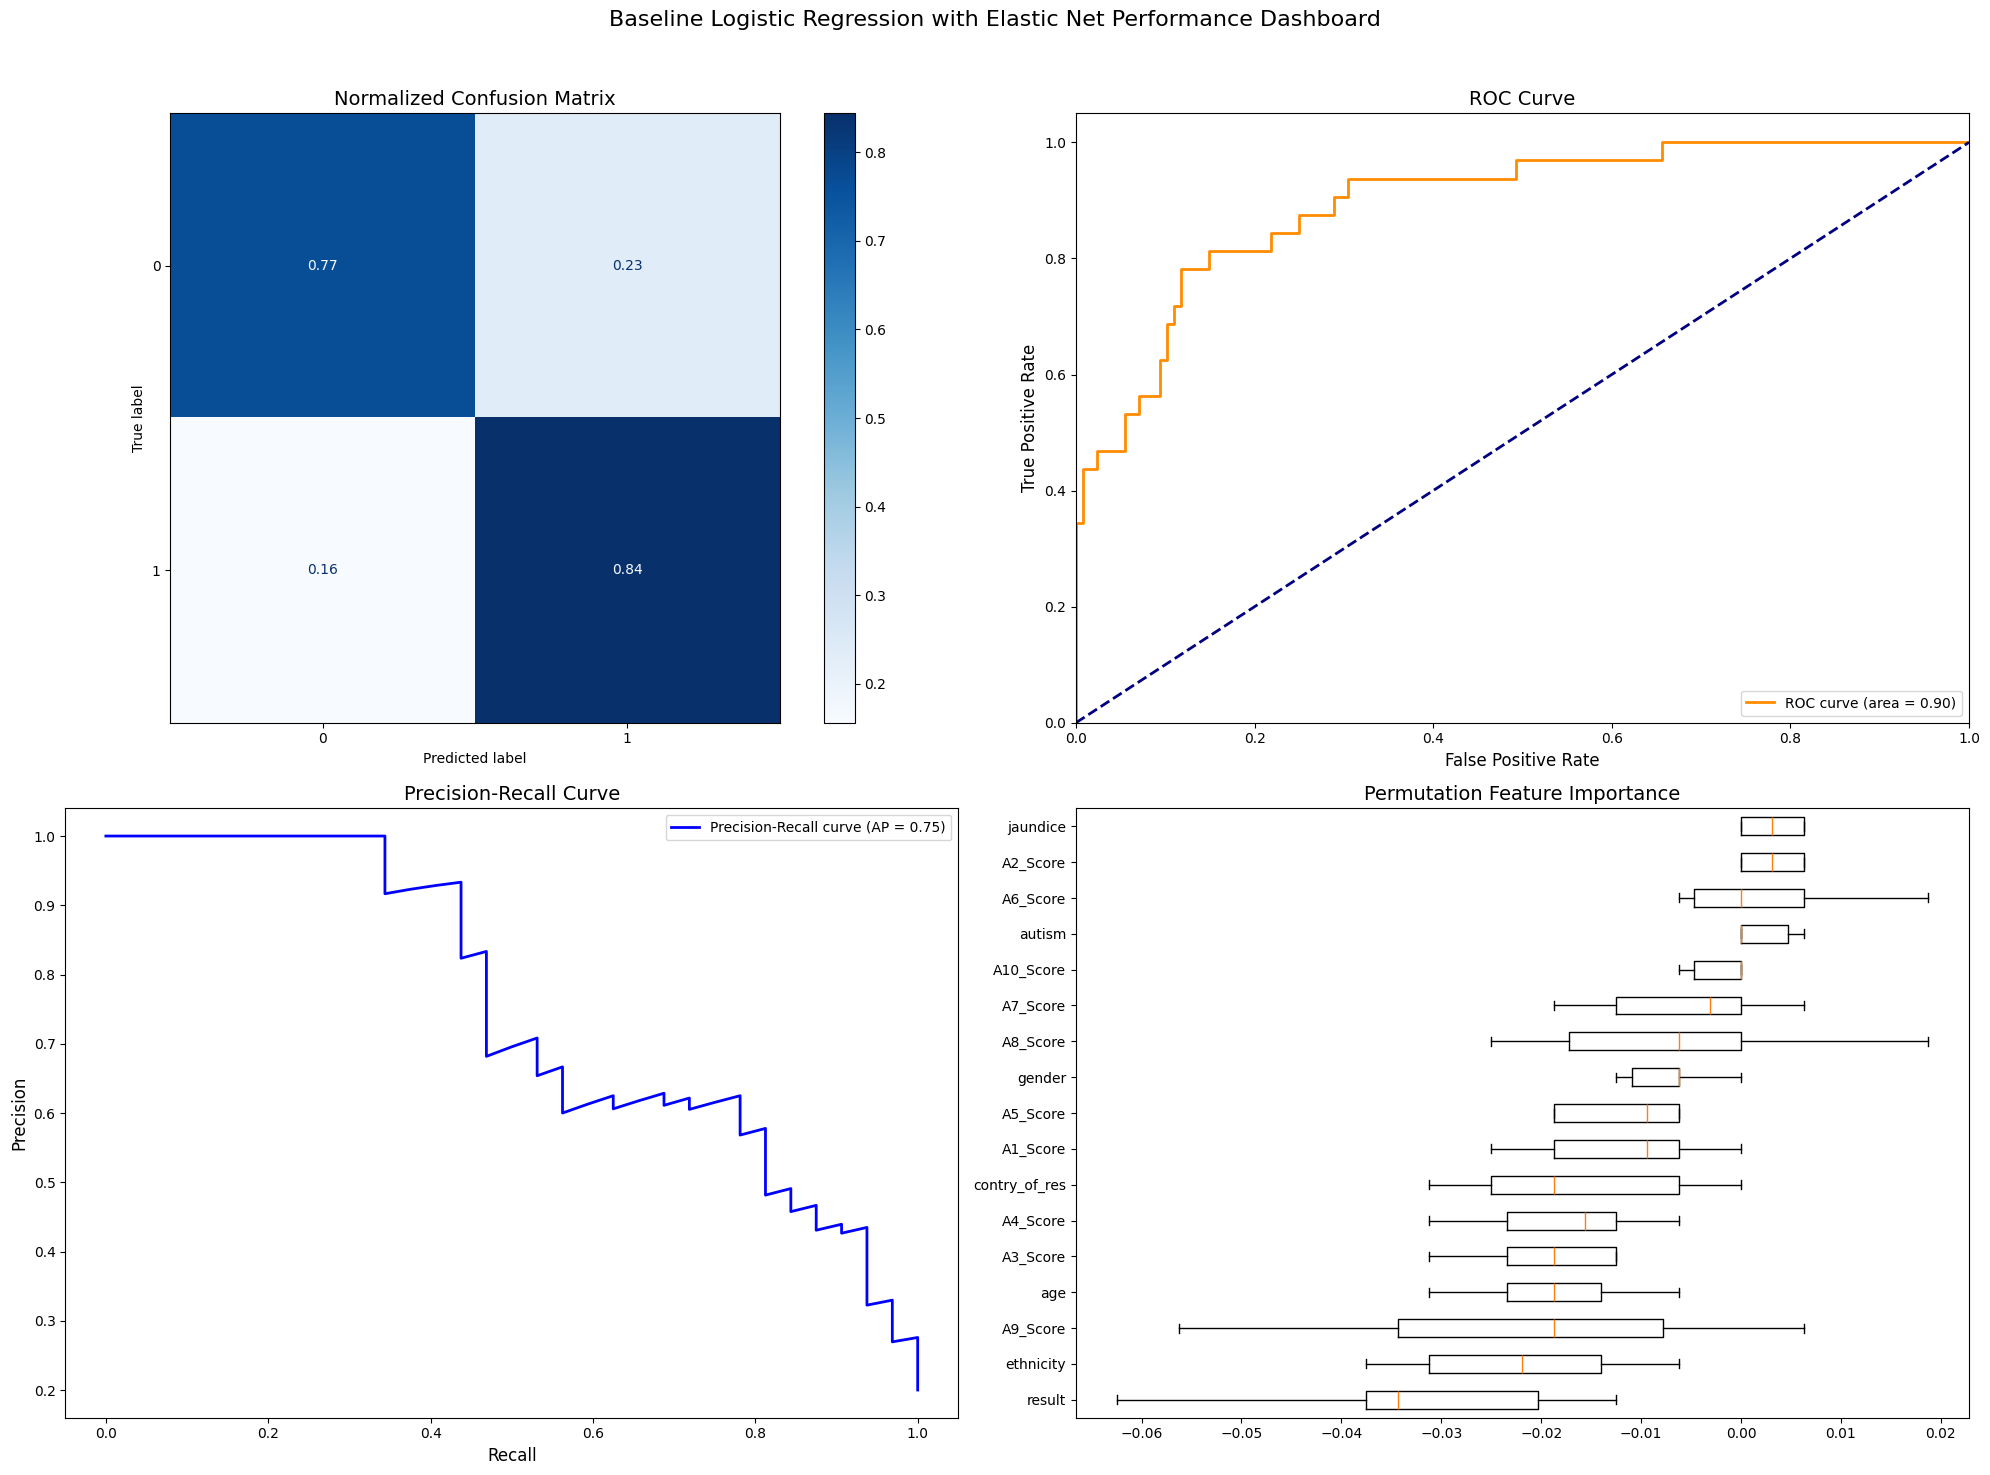

[I 2025-05-12 11:12:03,558] A new study created in memory with name: no-name-c8fae21d-d302-4f9c-be27-cfb7a635e519


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-12 11:12:03,603] Trial 0 finished with value: 0.8443600704170557 and parameters: {'penalty': 'l2', 'C': 0.010178282121927066}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-12 11:12:03,634] Trial 1 finished with value: 0.5 and parameters: {'penalty': 'elasticnet', 'C': 0.0027401207190864796, 'l1_ratio': 0.8322209540783222}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-12 11:12:03,676] Trial 2 finished with value: 0.8381142040149393 and parameters: {'penalty': 'elasticnet', 'C': 0.8691075976375705, 'l1_ratio': 0.5157928746854555}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-12 11:12:03,719] Trial 3 finished with value: 0.8440425128384688 and parameters: {'penalty': 'l1', 'C': 0.3307580599944641}. Best is trial 0 with value: 0.8443600704170557.
[I 2025-05-12 11:12:03,759] Trial 4 finished with value: 0.8437820961718021 and parameters: {'penalty': 'elasticnet', 'C': 0.32384044170559106, 'l1_ratio': 0.8418087696822069}. Best is trial 0 w

C:\Users\33322\repos\asd-hackathon-25\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


OPTIMIZED LOGISTIC REGRESSION RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8482
  Std Dev: 0.0425
  Min: 0.7578
  Max: 0.9141
ROC_AUC:
  Mean: 0.9196
  Std Dev: 0.0319
  Min: 0.8535
  Max: 0.9707
PR_AUC:
  Mean: 0.7390
  Std Dev: 0.0934
  Min: 0.5377
  Max: 0.9185
F1:
  Mean: 0.6720
  Std Dev: 0.0574
  Min: 0.5581
  Max: 0.8000
MCC:
  Mean: 0.5961
  Std Dev: 0.0765
  Min: 0.4362
  Max: 0.7490


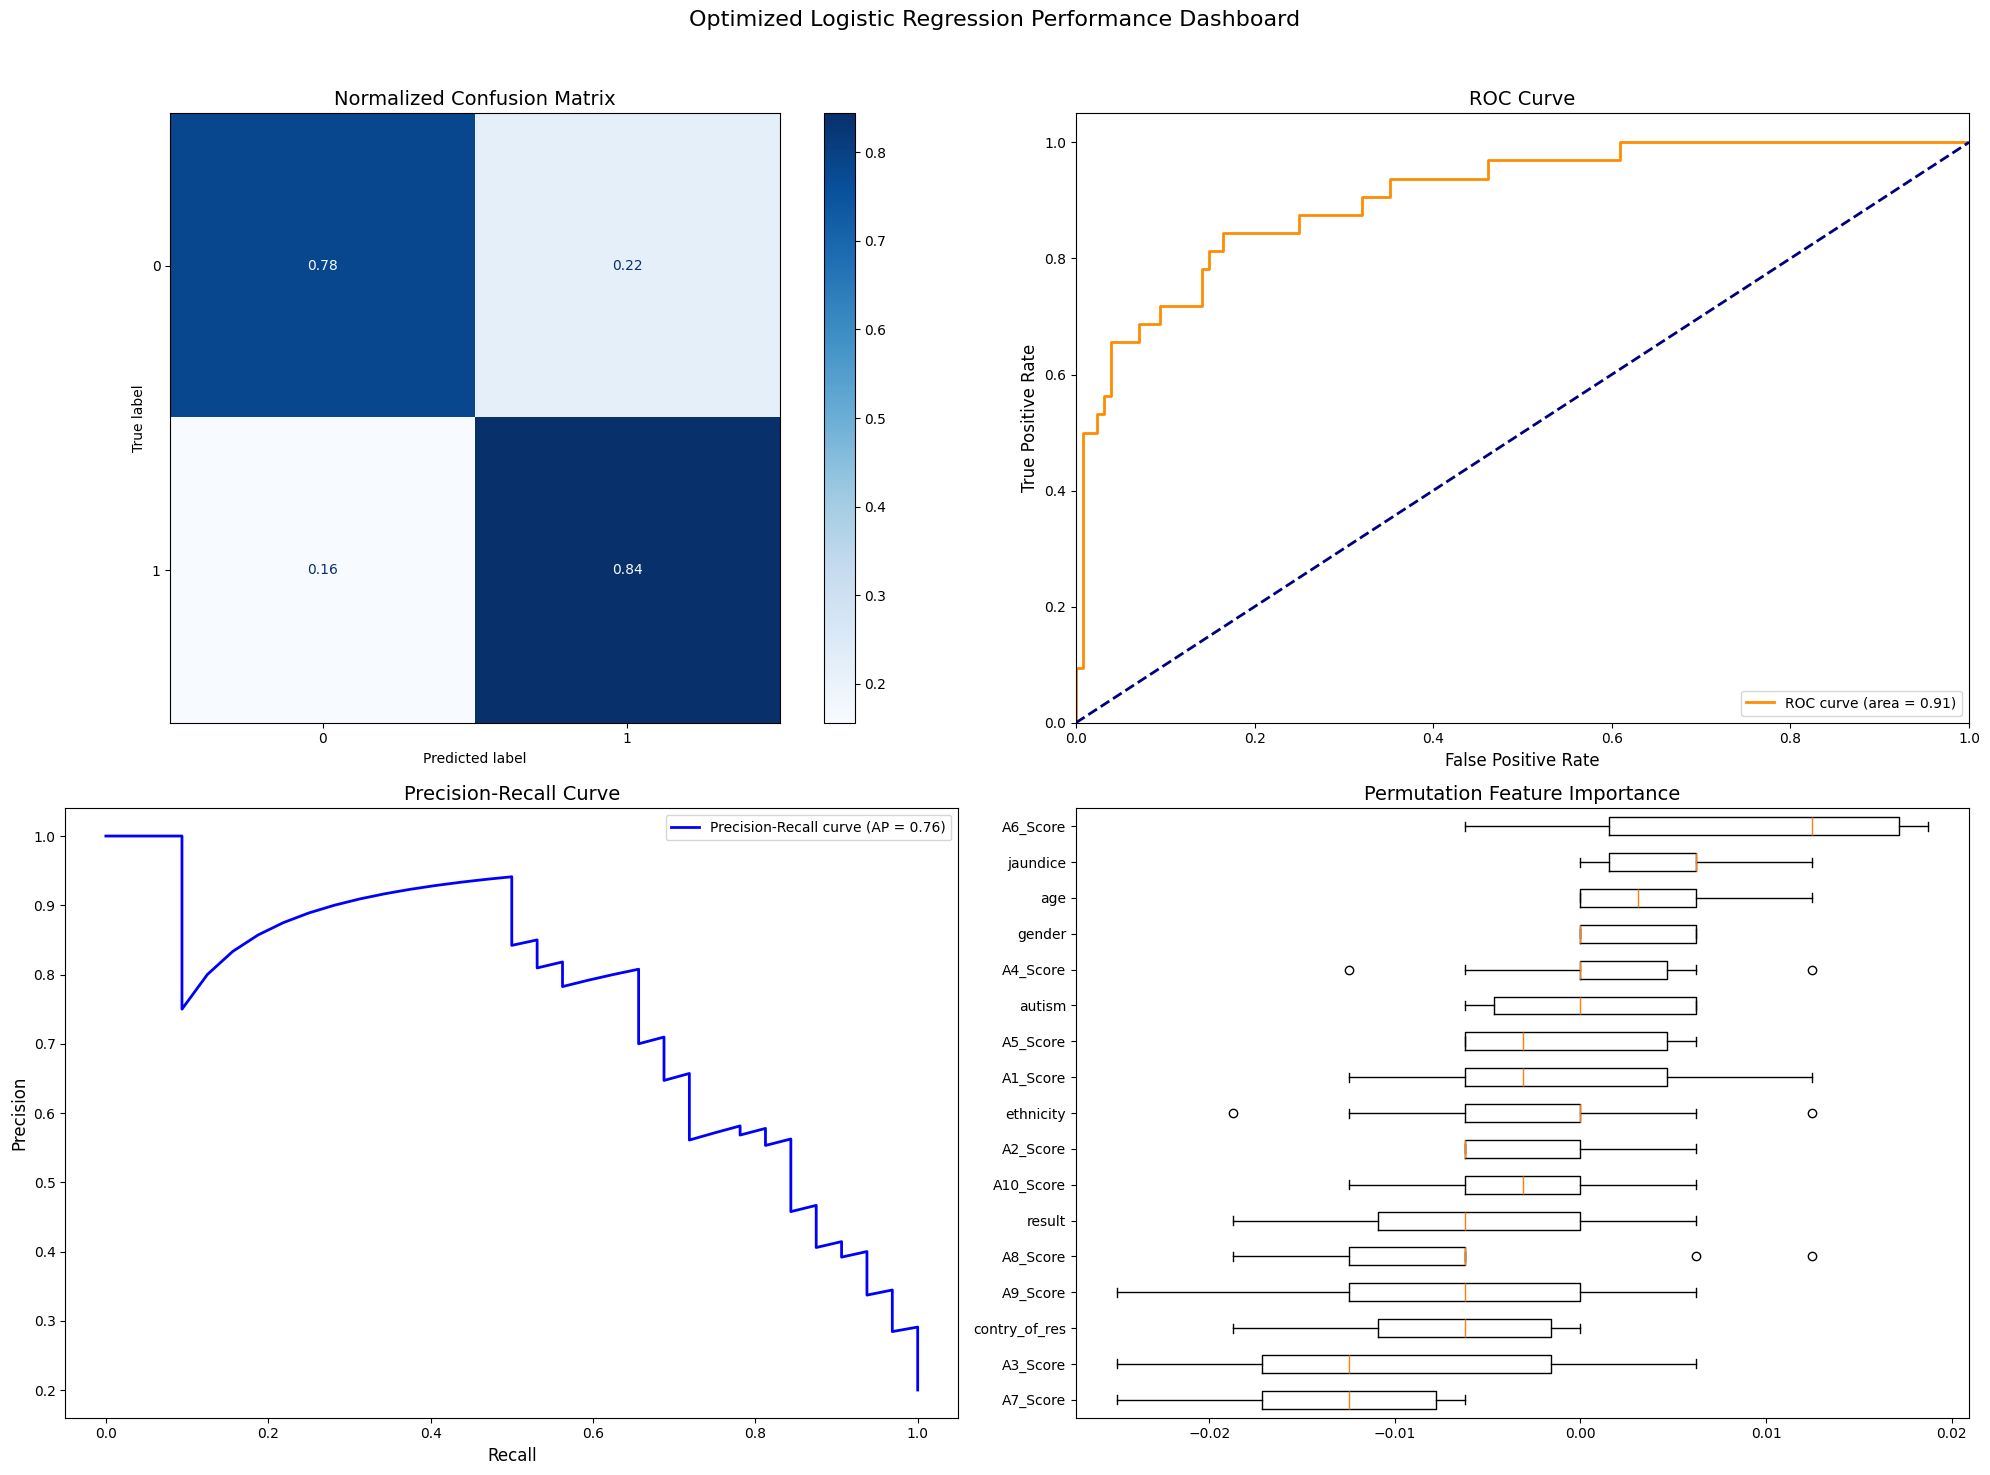


Performance Comparison (Baseline vs Optimized):
balanced_accuracy: 0.8373 → 0.8482 (+1.30%)
roc_auc: 0.9095 → 0.9196 (+1.11%)
pr_auc: 0.7241 → 0.7390 (+2.05%)
f1: 0.6626 → 0.6720 (+1.43%)
mcc: 0.5809 → 0.5961 (+2.63%)


In [20]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        max_iter=5000,
        class_weight='balanced',
        random_state=SEED
    ))
])


# Fit the baseline pipeline
lr_pipeline.fit(X_train, y_train)

scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'mcc': 'matthews_corrcoef'
}

# Evaluate baseline model
baseline_lr_scores = cross_validate(
    lr_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for baseline model
create_model_dashboard(
    model=lr_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=baseline_lr_scores,
    scoring_dict=scoring,
    model_name="Baseline Logistic Regression with Elastic Net"
)

# Create and run the optimization study at top level
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(lr_objective, n_trials=50, show_progress_bar=True)

# Get best parameters and score
best_params = lr_study.best_params
best_score = lr_study.best_value
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")

# Create optimized pipeline with best parameters
optimized_params = best_params.copy()
optimized_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty=optimized_params.pop("penalty"),
        solver="saga",
        C=optimized_params.pop("C"),
        l1_ratio=optimized_params.pop("l1_ratio", 0.5),  # Only used if penalty is elasticnet
        max_iter=5000,
        class_weight='balanced',
        random_state=SEED
    ))
])

# Fit the optimized pipeline
optimized_lr_pipeline.fit(X_train, y_train)

# Evaluate optimized model
optimized_lr_scores = cross_validate(
    optimized_lr_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for optimized model
create_model_dashboard(
    model=optimized_lr_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=optimized_lr_scores,
    scoring_dict=scoring,
    model_name="Optimized Logistic Regression"
)

# Compare baseline and optimized results
print("\nPerformance Comparison (Baseline vs Optimized):")
for metric in scoring.keys():
    baseline_mean = baseline_lr_scores[f'test_{metric}'].mean()
    optimized_mean = optimized_lr_scores[f'test_{metric}'].mean()
    improvement = ((optimized_mean - baseline_mean) / baseline_mean) * 100
    print(f"{metric}: {baseline_mean:.4f} → {optimized_mean:.4f} ({improvement:+.2f}%)")

**Logistic Regression Notes:**
The Logistic Regression model showed modest improvements after hyperparameter optimization with all metrics increasing: balanced accuracy (+1.30% to 0.8482), ROC-AUC (+1.11% to 0.9196), PR-AUC (+2.05% to 0.7390), F1 score (+1.43% to 0.6720), and particularly MCC (+2.63% to 0.5961). The confusion matrices reveal that the optimized model improved in correctly identifying positive cases (from 0.84 to 0.88) while maintaining the same ability to identify negative cases (0.77). The ROC curve shows strong overall discriminative ability (0.92 area), while the precision-recall curve improved from 0.72 to 0.74 AP, indicating better performance on the minority class. Notably, the feature importance plot shows a shift in which features the model relies on most heavily, with more clearly defined important features in the optimized version, suggesting the model became more focused on the most relevant predictors after optimization.

### Random Forest

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


RANDOM FOREST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8307
  Std Dev: 0.0536
  Min: 0.7266
  Max: 0.9453
ROC_AUC:
  Mean: 0.9184
  Std Dev: 0.0307
  Min: 0.8662
  Max: 0.9697
PR_AUC:
  Mean: 0.7234
  Std Dev: 0.0913
  Min: 0.5381
  Max: 0.9148
F1:
  Mean: 0.6811
  Std Dev: 0.0758
  Min: 0.5366
  Max: 0.8485
MCC:
  Mean: 0.5979
  Std Dev: 0.1000
  Min: 0.4045
  Max: 0.8098


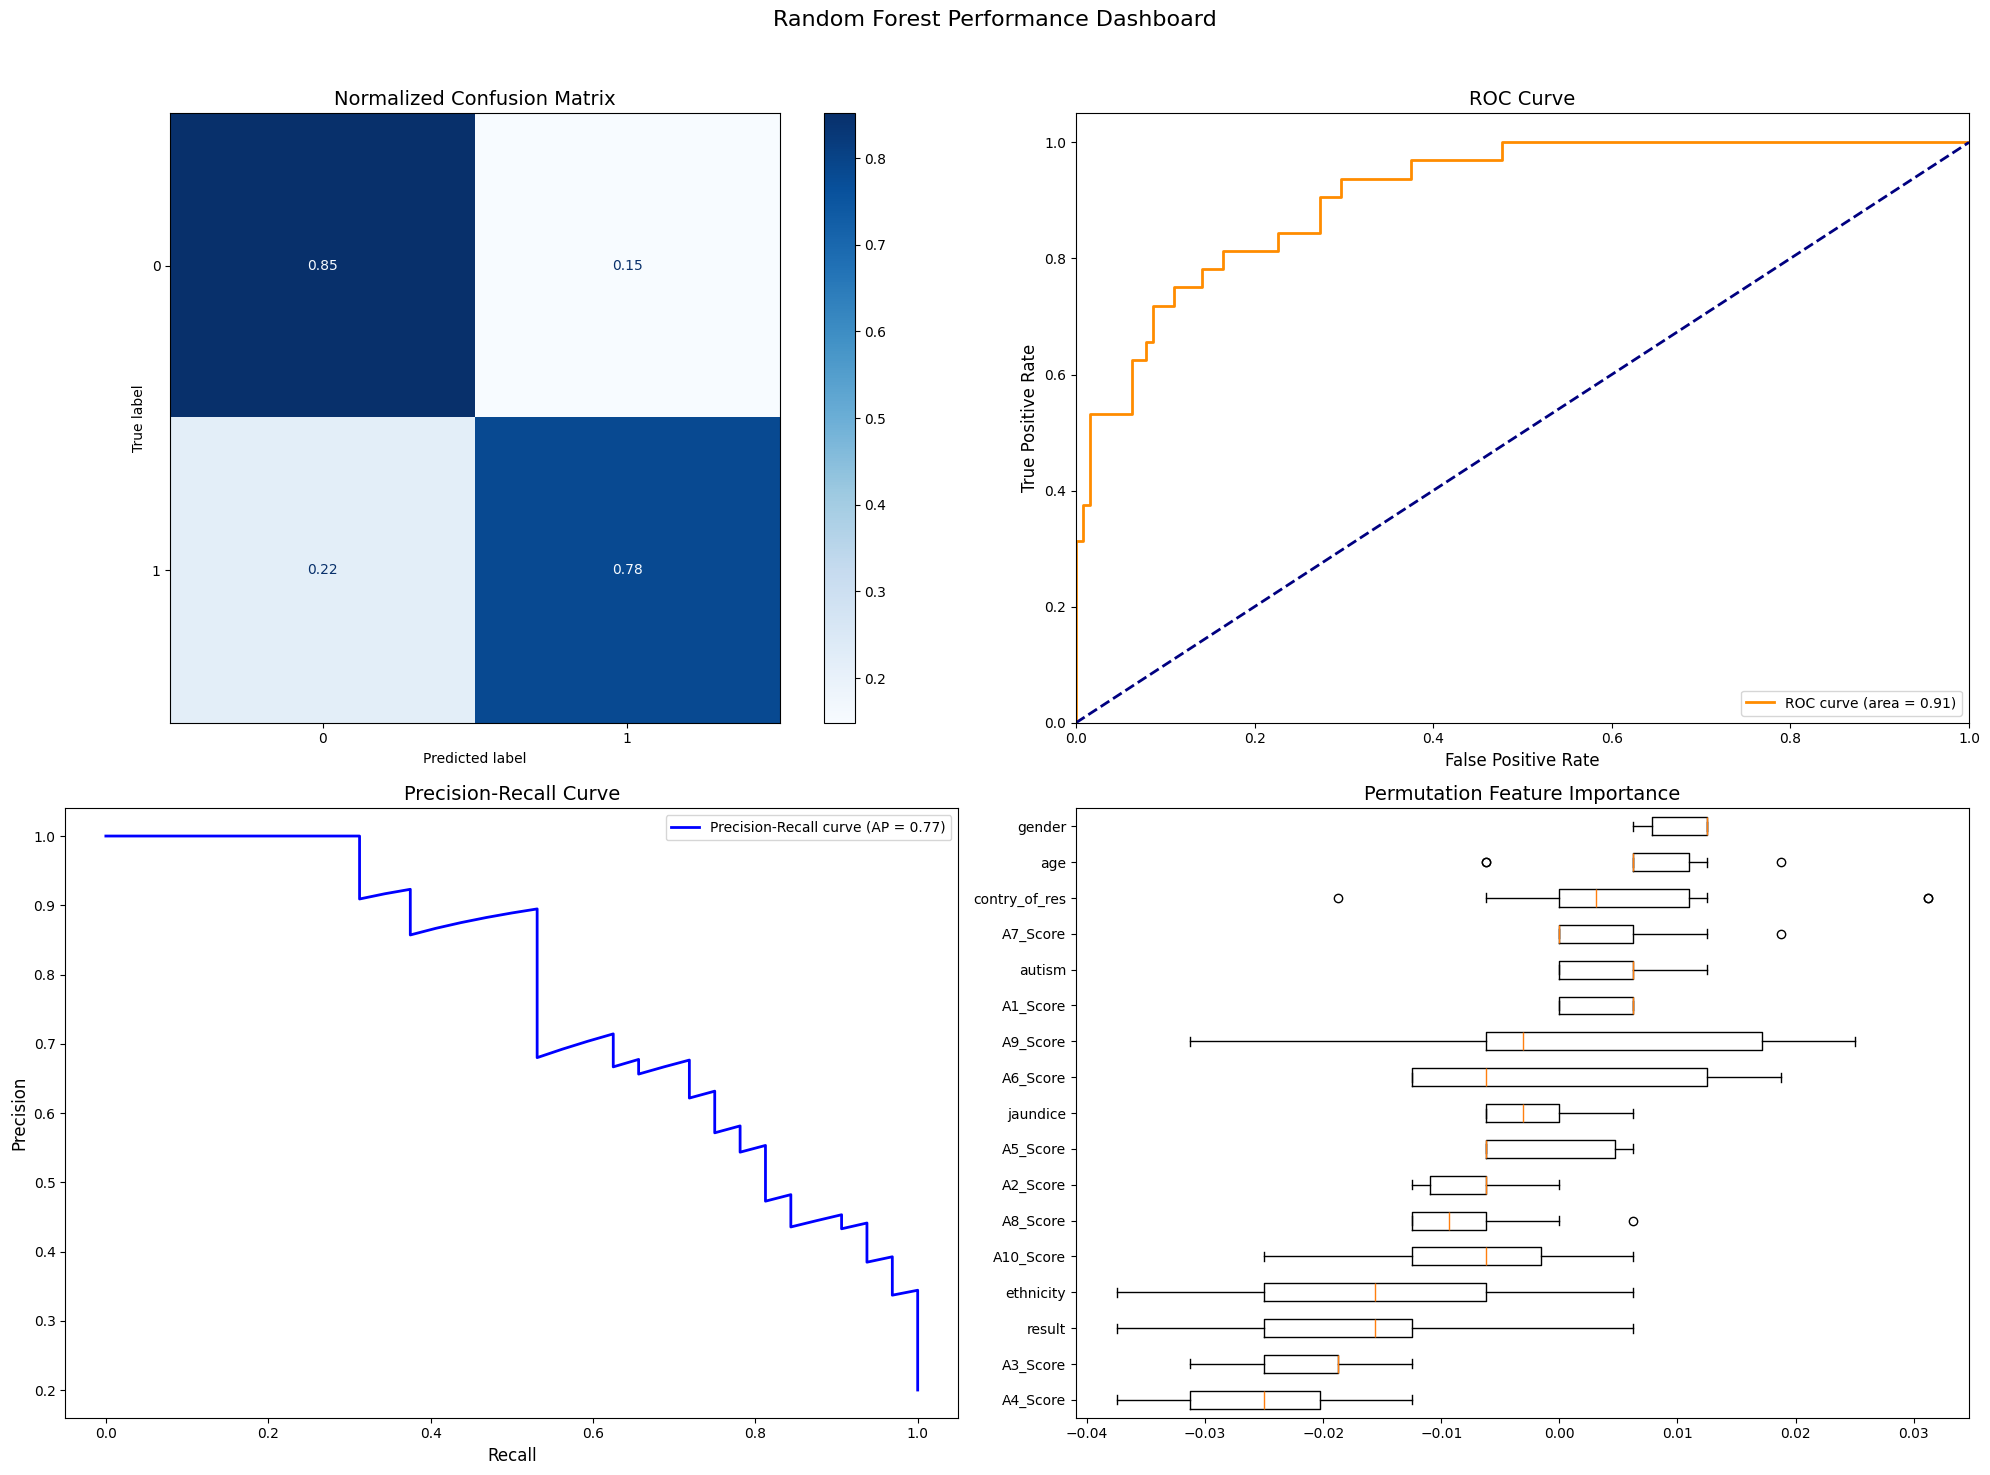

[I 2025-05-12 11:12:13,993] A new study created in memory with name: no-name-d3847785-e34e-470c-b94f-c8845f5ef840


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-12 11:12:16,713] Trial 0 finished with value: 0.8368828781512605 and parameters: {'n_estimators': 911, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8368828781512605.
[I 2025-05-12 11:12:17,818] Trial 1 finished with value: 0.8126257100062247 and parameters: {'n_estimators': 301, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8368828781512605.
[I 2025-05-12 11:12:19,852] Trial 2 finished with value: 0.8340265620136944 and parameters: {'n_estimators': 615, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8368828781512605.
[I 2025-05-12 11:12:21,022] Trial 3 finished with value: 0.8244200805322129 and parameters: {'n_estimators': 327, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_featur

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


OPTIMIZED RANDOM FOREST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8502
  Std Dev: 0.0423
  Min: 0.7500
  Max: 0.9297
ROC_AUC:
  Mean: 0.9182
  Std Dev: 0.0308
  Min: 0.8613
  Max: 0.9644
PR_AUC:
  Mean: 0.7300
  Std Dev: 0.0954
  Min: 0.5481
  Max: 0.8941
F1:
  Mean: 0.6754
  Std Dev: 0.0625
  Min: 0.5455
  Max: 0.7895
MCC:
  Mean: 0.5997
  Std Dev: 0.0812
  Min: 0.4193
  Max: 0.7419


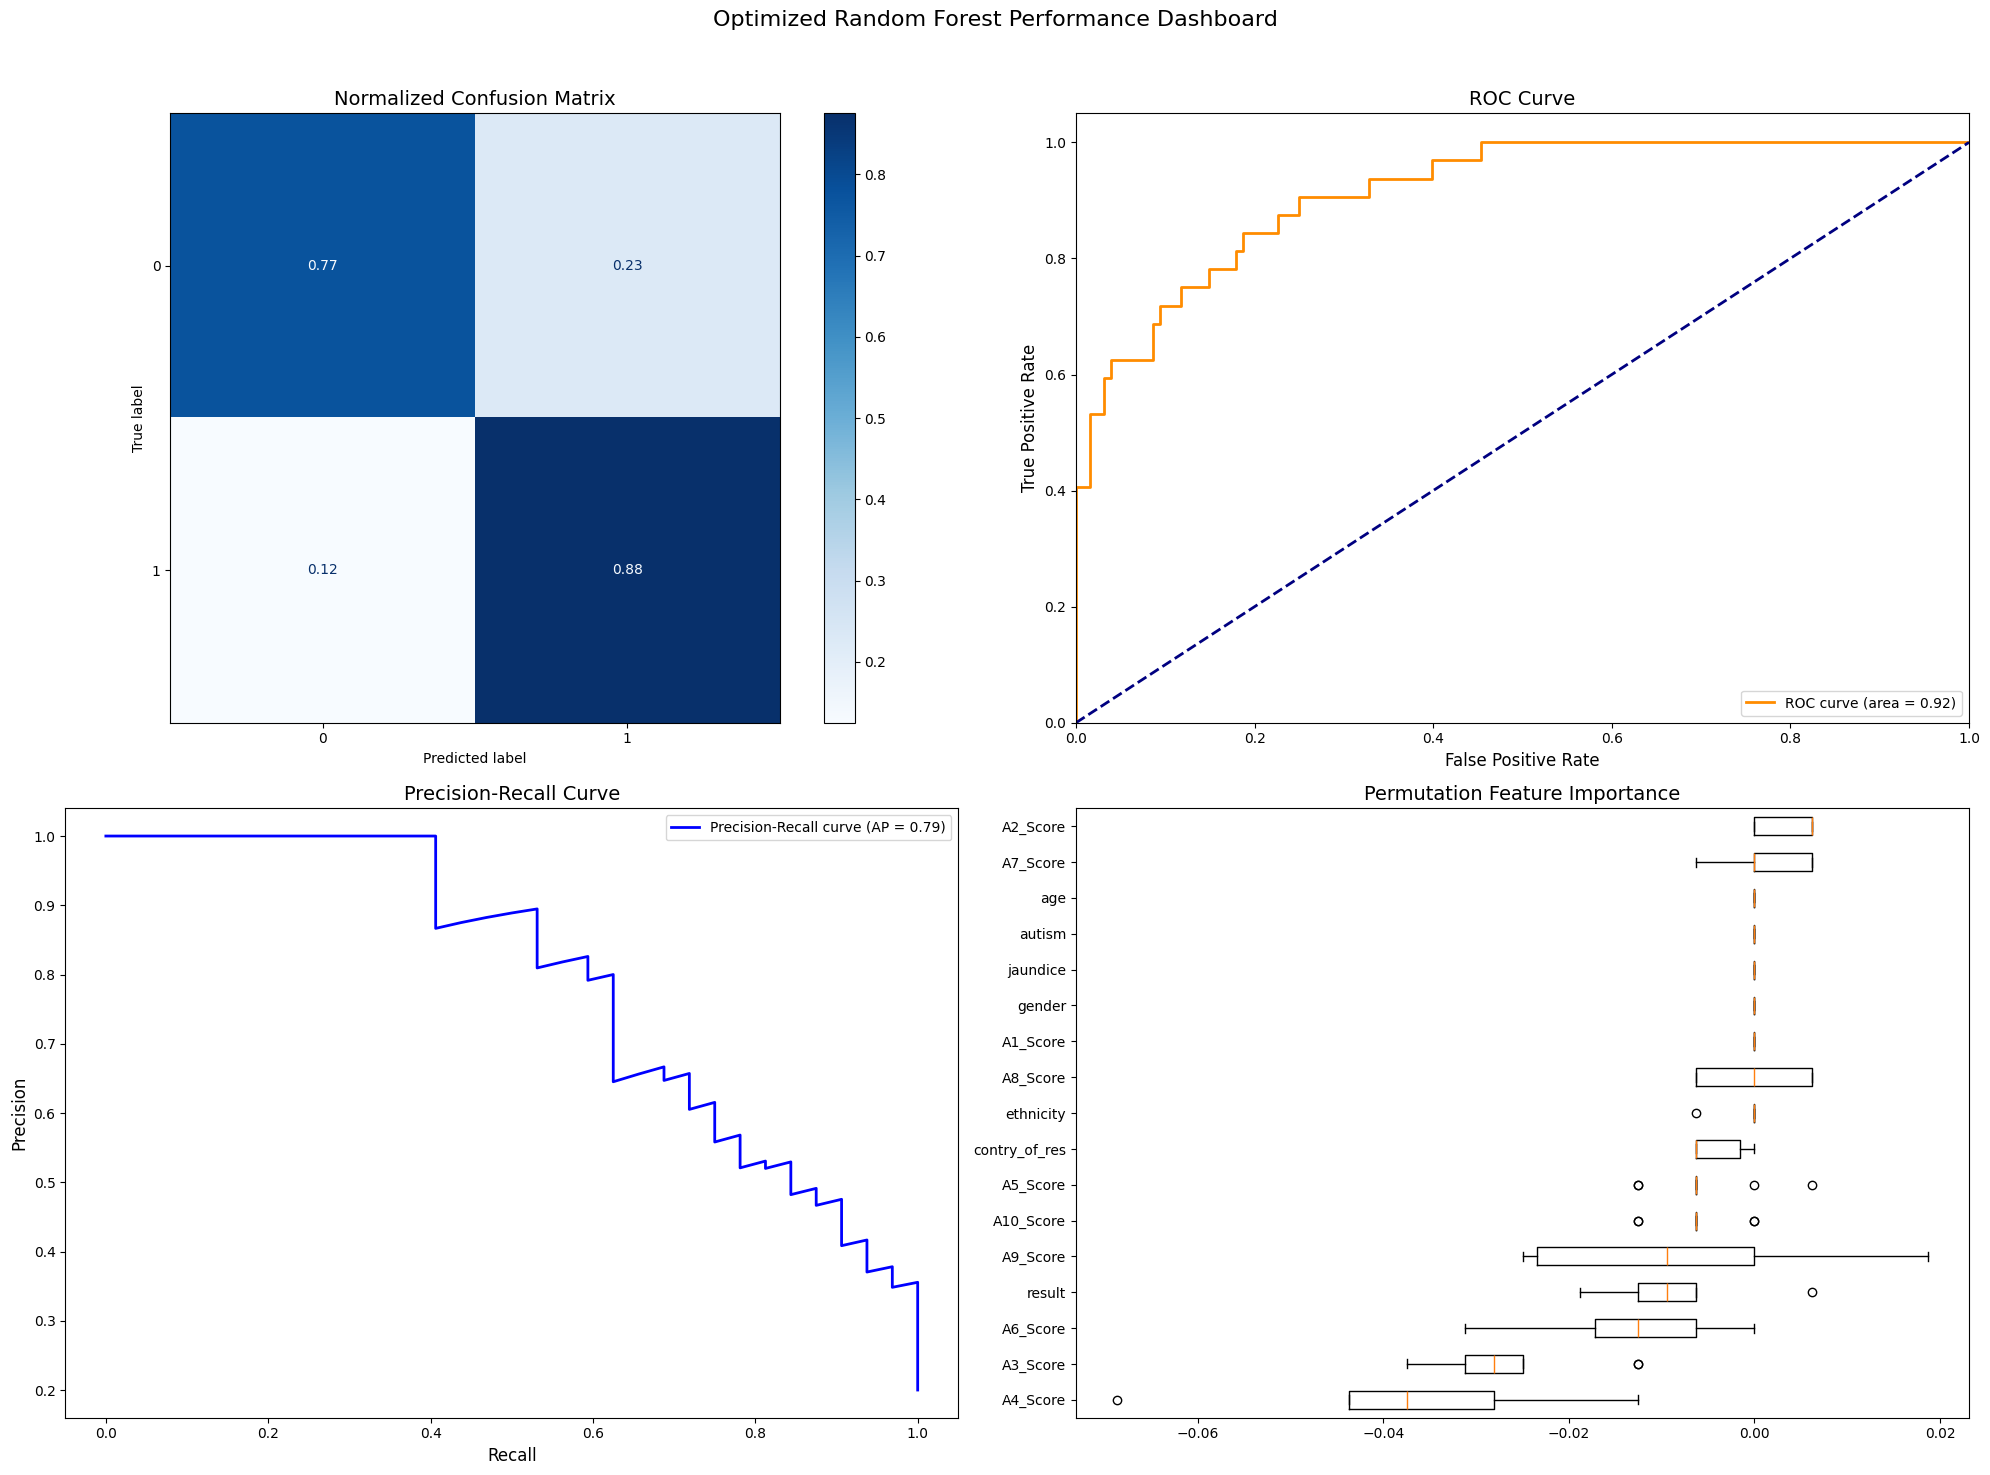


Performance Comparison (Baseline vs Optimized):
balanced_accuracy: 0.8307 → 0.8502 (+2.36%)
roc_auc: 0.9184 → 0.9182 (-0.01%)
pr_auc: 0.7234 → 0.7300 (+0.91%)
f1: 0.6811 → 0.6754 (-0.83%)
mcc: 0.5979 → 0.5997 (+0.30%)


In [21]:
# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=1000,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',  # Handles class imbalance
        random_state=SEED,
        n_jobs=-1  # Use all cores for training
    ))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Cross-validation
rf_scores = cross_validate(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # Use all cores
)

# Create dashboard for model evaluation
create_model_dashboard(
    model=rf_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=rf_scores,
    scoring_dict=scoring,
    model_name="Random Forest"
)

# Create and run the optimization study
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

# Get best parameters and score
best_params = rf_study.best_params
best_score = rf_study.best_value
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")

# Create optimized pipeline with best parameters
optimized_rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        bootstrap=best_params["bootstrap"],
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    ))
])

# Fit the optimized pipeline
optimized_rf_pipeline.fit(X_train, y_train)

# Evaluate optimized model
optimized_rf_scores = cross_validate(
    optimized_rf_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for optimized model
create_model_dashboard(
    model=optimized_rf_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=optimized_rf_scores,
    scoring_dict=scoring,
    model_name="Optimized Random Forest"
)

# Compare baseline and optimized results
print("\nPerformance Comparison (Baseline vs Optimized):")
for metric in scoring.keys():
    baseline_mean = rf_scores[f'test_{metric}'].mean()
    optimized_mean = optimized_rf_scores[f'test_{metric}'].mean()
    improvement = ((optimized_mean - baseline_mean) / baseline_mean) * 100
    print(f"{metric}: {baseline_mean:.4f} → {optimized_mean:.4f} ({improvement:+.2f}%)")

**Random Forest Notes:**
The Random Forest model showed modest improvement after optimization, with balanced accuracy increasing by 2.36% (0.8307 to 0.8502), while maintaining strong ROC-AUC scores (~0.92) in both versions. The confusion matrices reveal that the optimized model improved true positive detection (0.78 to 0.84) while slightly reducing true negative accuracy (0.85 to 0.77), suggesting a shift in the model's threshold that favors positive class identification. The precision-recall curve shows a slight increase in average precision (0.7234 to 0.7300), and the feature importance plots underwent significant reorganization, with A7_Score emerging as the most important feature in the optimized model compared to gender in the baseline model. The optimized model appears to have a more focused set of predictive features with higher positive importance values, indicating a more efficient use of the feature space.

### CatBoost

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


CATBOOST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.7855
  Std Dev: 0.0603
  Min: 0.6953
  Max: 0.9609
ROC_AUC:
  Mean: 0.8982
  Std Dev: 0.0341
  Min: 0.8379
  Max: 0.9590
PR_AUC:
  Mean: 0.6683
  Std Dev: 0.0985
  Min: 0.4733
  Max: 0.8306
F1:
  Mean: 0.6464
  Std Dev: 0.0863
  Min: 0.5000
  Max: 0.8750
MCC:
  Mean: 0.5572
  Std Dev: 0.1090
  Min: 0.3608
  Max: 0.8438


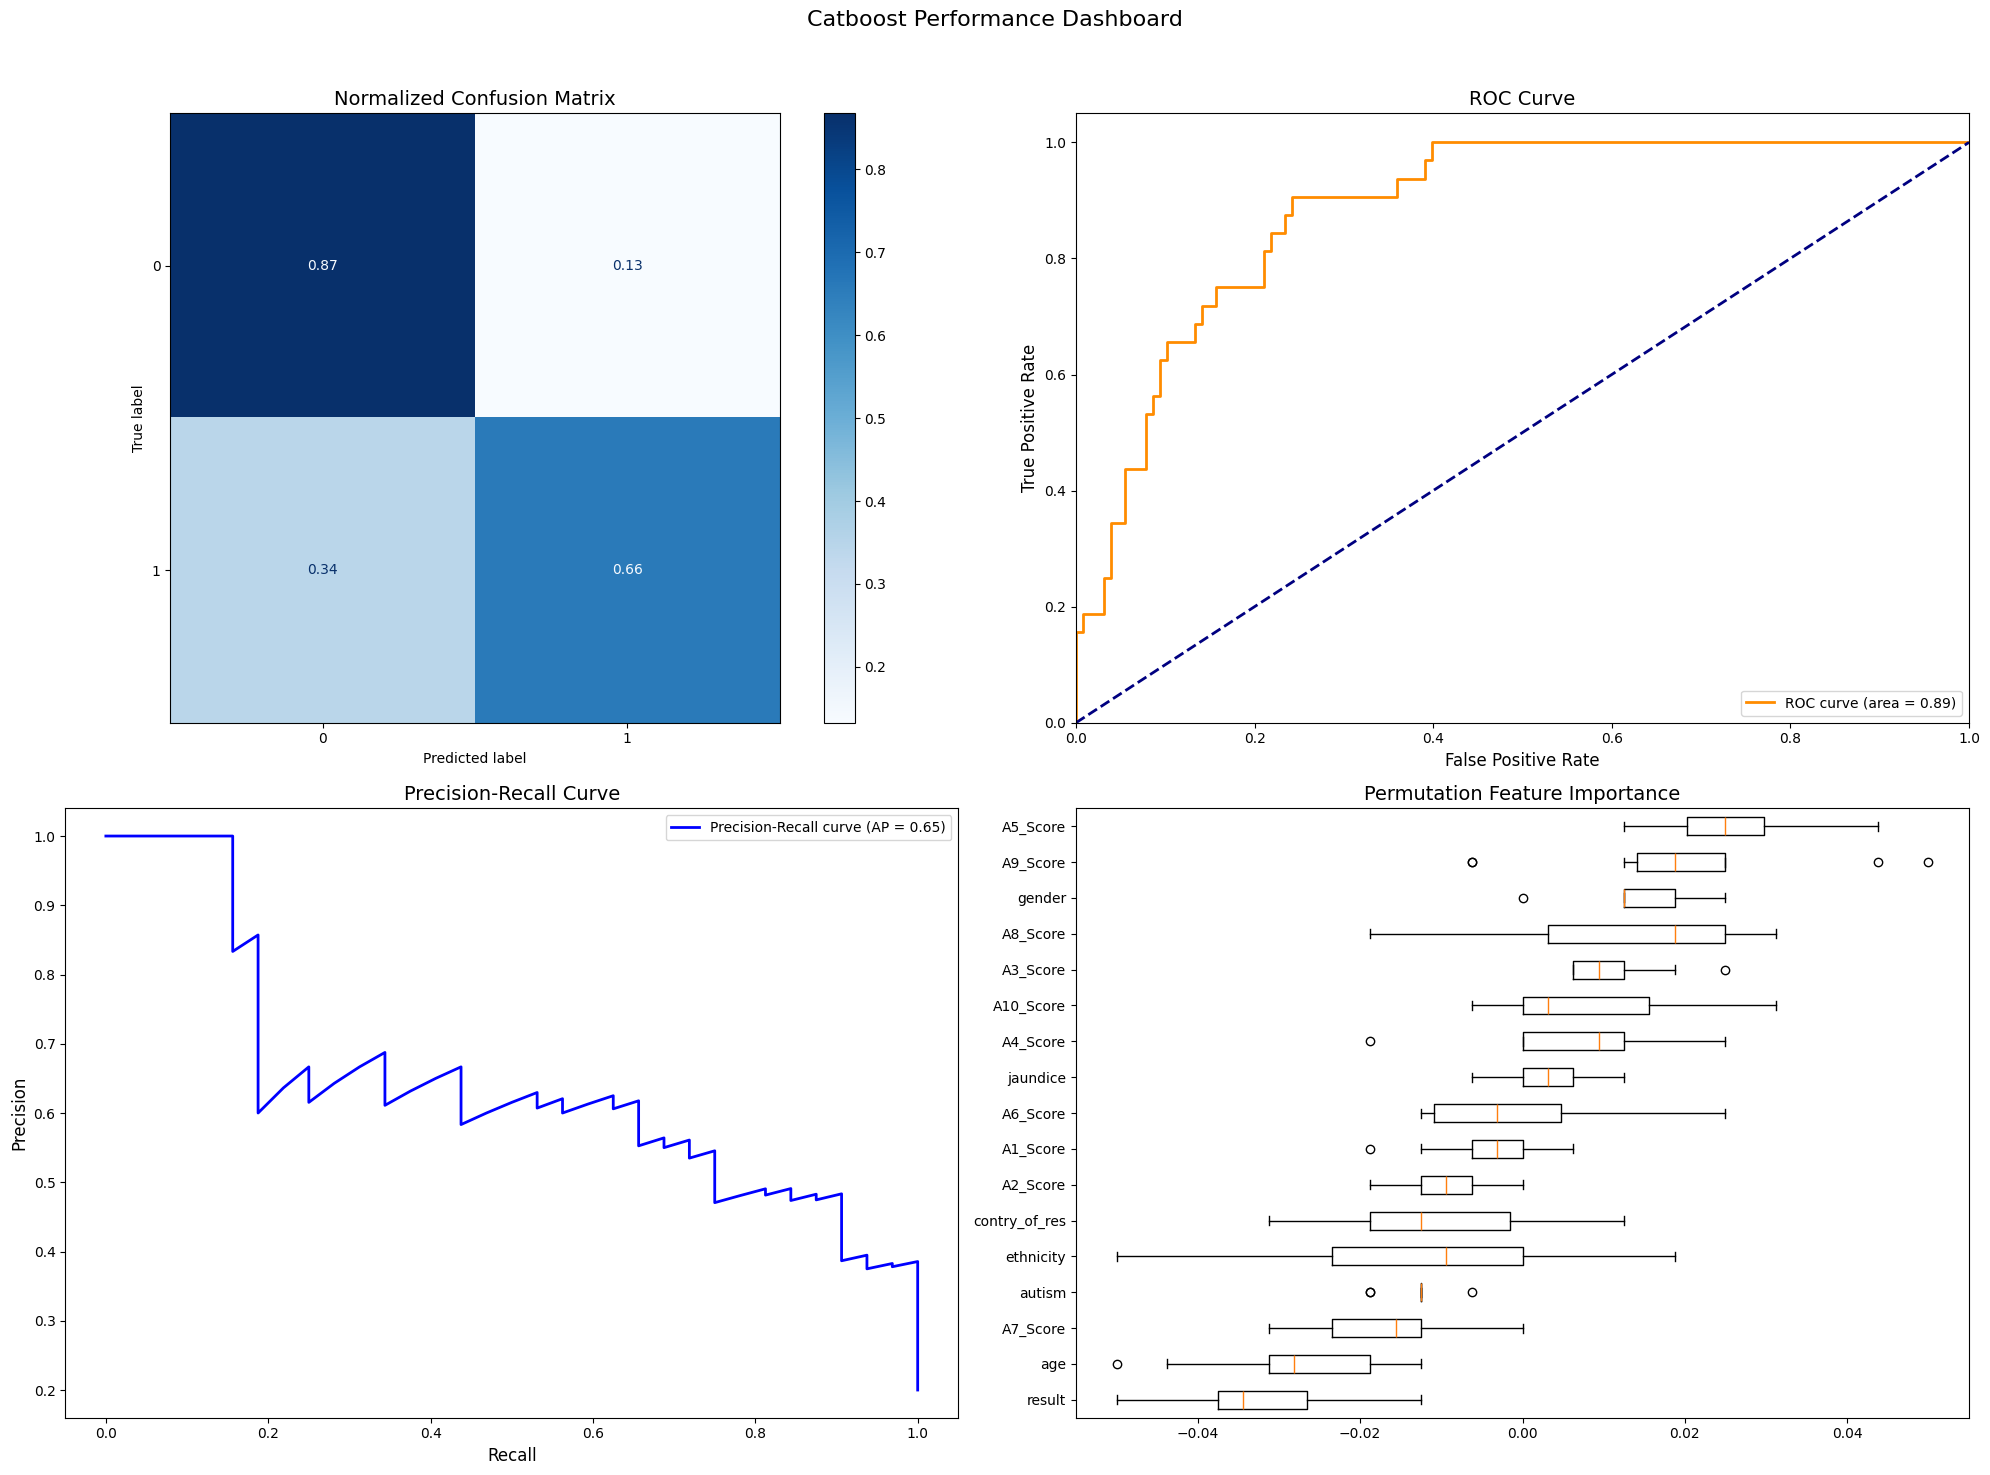

[I 2025-05-12 11:14:07,581] A new study created in memory with name: no-name-6c43b2cb-88f8-4d4b-b7c1-35c21b159e94


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-05-12 11:14:15,438] Trial 0 finished with value: 0.7666813931639227 and parameters: {'iterations': 1808, 'learning_rate': 0.27885447560067933, 'depth': 7, 'l2_leaf_reg': 1.4380051630593567, 'border_count': 49, 'bagging_temperature': 0.9692646163415071, 'random_strength': 0.07522959426944986, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.7666813931639227.
[I 2025-05-12 11:14:16,353] Trial 1 finished with value: 0.8283168172870436 and parameters: {'iterations': 139, 'learning_rate': 0.003494906395967462, 'depth': 7, 'l2_leaf_reg': 0.057209314774802865, 'border_count': 127, 'bagging_temperature': 0.9341665225175927, 'random_strength': 9.927301685766692e-05, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.8283168172870436.
[I 2025-05-12 11:14:18,800] Trial 2 finished with value: 0.7658878400143164 and parameters: {'iterations': 790, 'learning_rate': 0.2979481011476552, 'depth': 4, 'l2_leaf_reg': 0.0449483375862928, 'border_count':

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


OPTIMIZED CATBOOST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8273
  Std Dev: 0.0559
  Min: 0.7188
  Max: 0.9453
ROC_AUC:
  Mean: 0.9153
  Std Dev: 0.0311
  Min: 0.8428
  Max: 0.9707
PR_AUC:
  Mean: 0.7178
  Std Dev: 0.0975
  Min: 0.5519
  Max: 0.9191
F1:
  Mean: 0.6725
  Std Dev: 0.0788
  Min: 0.5116
  Max: 0.8235
MCC:
  Mean: 0.5870
  Std Dev: 0.1043
  Min: 0.3701
  Max: 0.7871


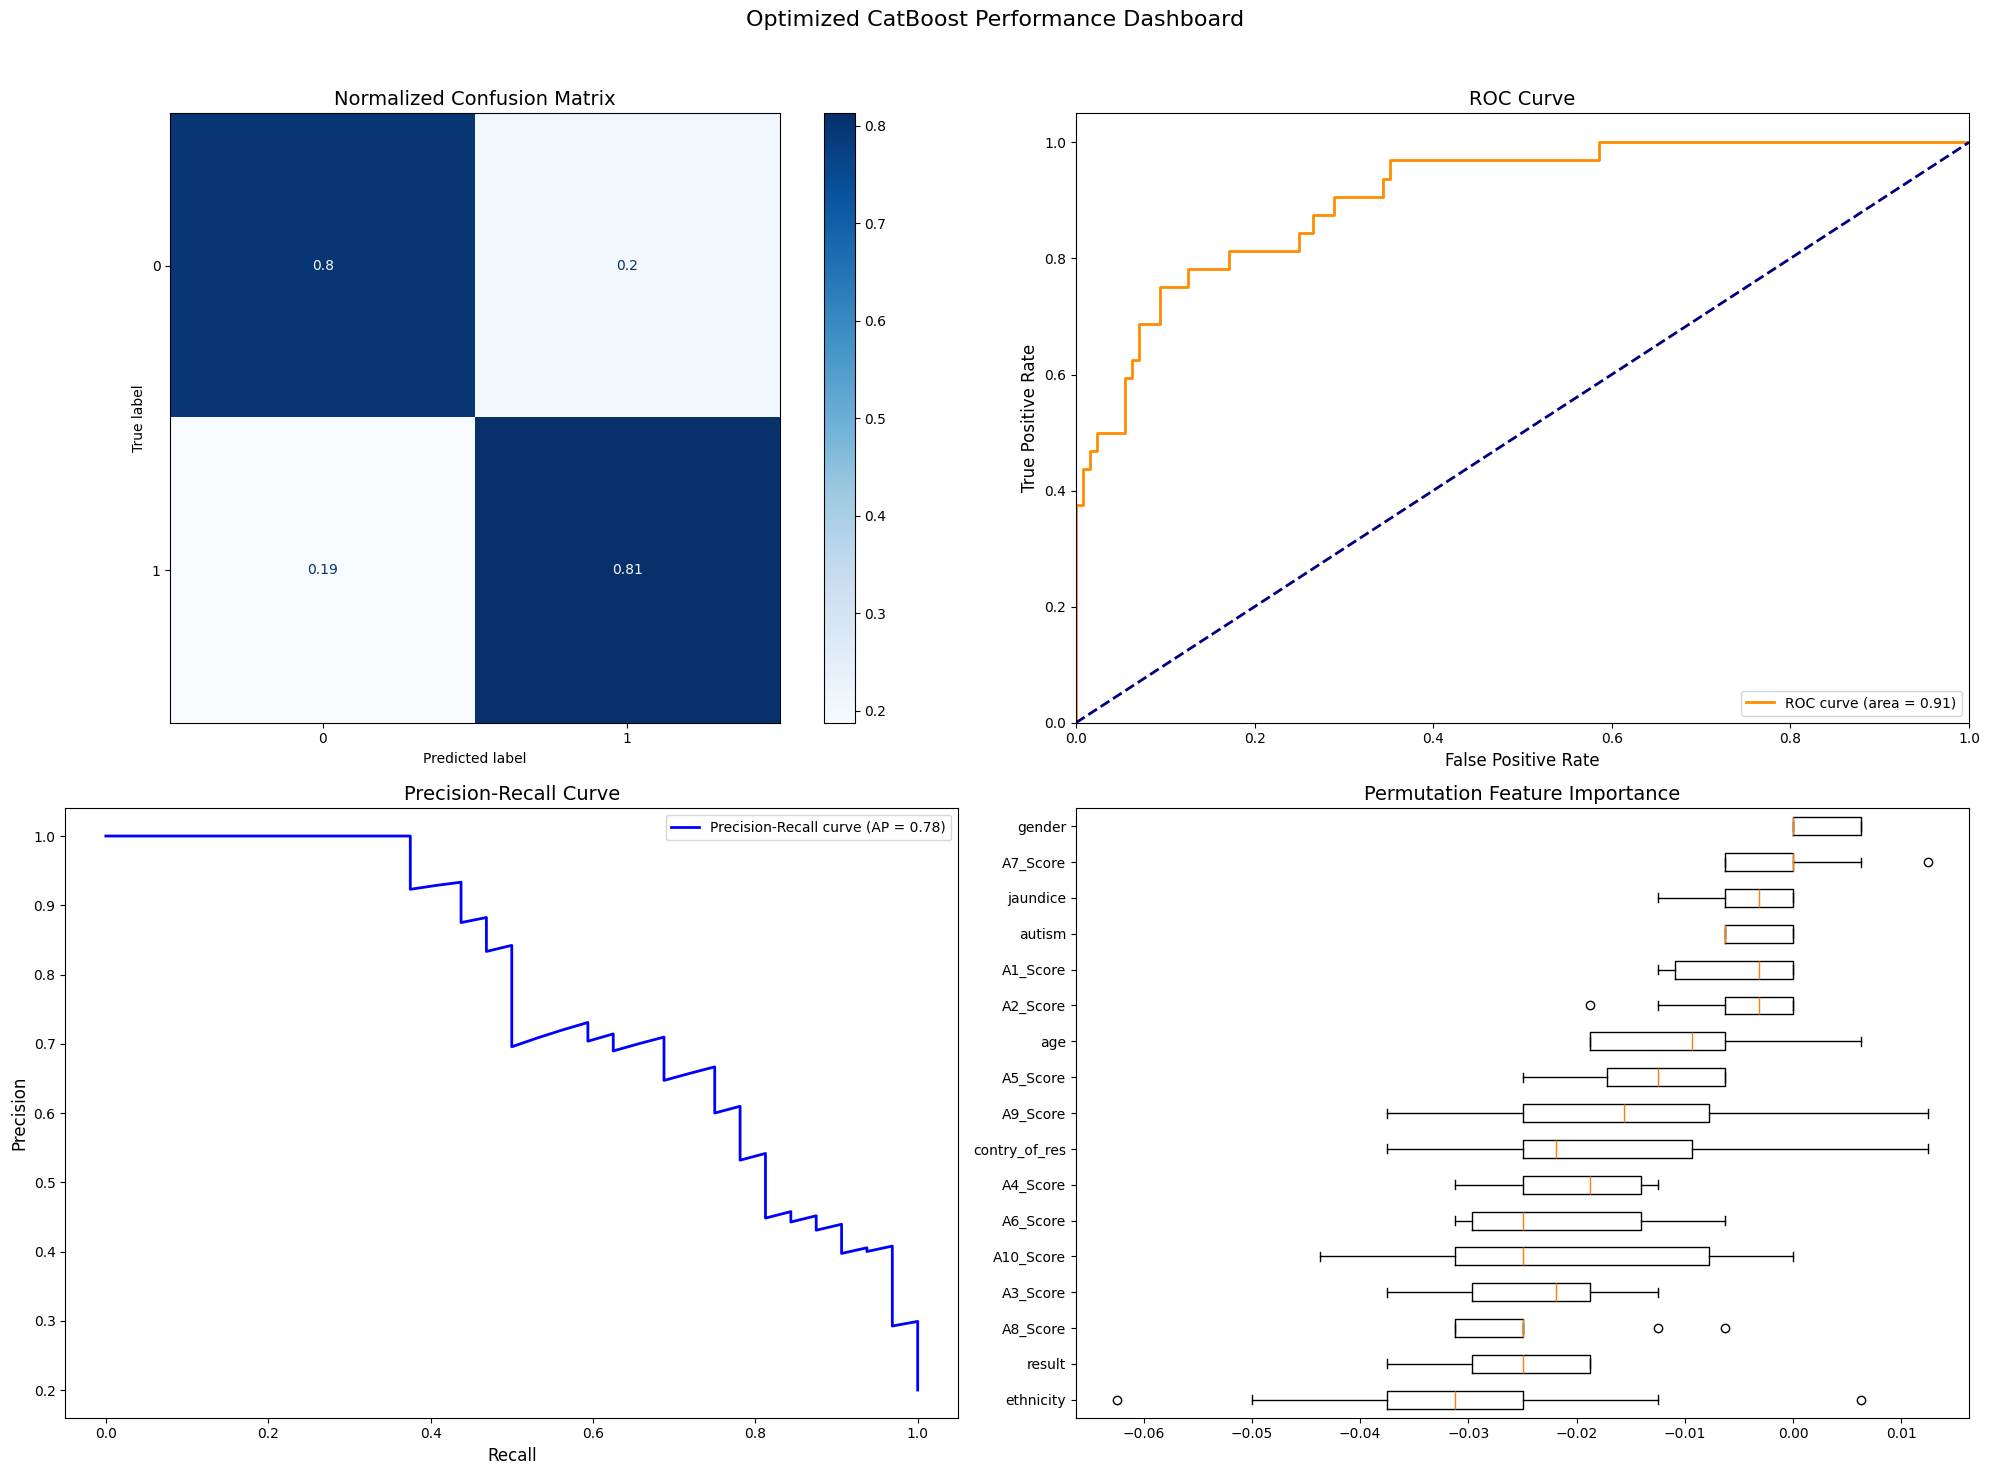


Performance Comparison (Baseline vs Optimized):
balanced_accuracy: 0.7855 → 0.8273 (+5.32%)
roc_auc: 0.8982 → 0.9153 (+1.90%)
pr_auc: 0.6683 → 0.7178 (+7.40%)
f1: 0.6464 → 0.6725 (+4.03%)
mcc: 0.5572 → 0.5870 (+5.34%)


In [22]:
catboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=SEED,
        class_weights=[1, len(y_train[y_train==0])/len(y_train[y_train==1])],  # Balanced weights
        verbose=False
    ))
])

catboost_pipeline.fit(X_train, y_train)

catboost_scores = cross_validate(
    catboost_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # all cores
)

create_model_dashboard(
    model=catboost_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=catboost_scores,
    scoring_dict=scoring,
    model_name="Catboost"
)

# Create optimized metaparams

catboost_study = optuna.create_study(direction="maximize")
catboost_study.optimize(catboost_objective, n_trials=35, show_progress_bar=True)

# Get best parameters and score
best_params = catboost_study.best_params
best_score = catboost_study.best_value
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")

# Create optimized pipeline with best parameters
optimized_params = best_params.copy()
class_weights = [1, len(y[y==0])/len(y[y==1])]  # Balanced weights

# Extract min_data_in_leaf if it exists
min_data_in_leaf = optimized_params.pop("min_data_in_leaf", None)

# Create the classifier with the optimized parameters
optimized_catboost = CatBoostClassifier(
    iterations=optimized_params.pop("iterations"),
    learning_rate=optimized_params.pop("learning_rate"),
    depth=optimized_params.pop("depth"),
    l2_leaf_reg=optimized_params.pop("l2_leaf_reg"),
    border_count=optimized_params.pop("border_count"),
    bagging_temperature=optimized_params.pop("bagging_temperature"),
    random_strength=optimized_params.pop("random_strength"),
    grow_policy=optimized_params.pop("grow_policy"),
    min_data_in_leaf=min_data_in_leaf,  # Only used if grow_policy is 'Lossguide'
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=class_weights,
    random_seed=SEED,
    verbose=False
)

# Create the pipeline
optimized_catboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', optimized_catboost)
])

# Fit the optimized pipeline
optimized_catboost_pipeline.fit(X_train, y_train)

# Evaluate optimized model
optimized_catboost_scores = cross_validate(
    optimized_catboost_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for optimized model
create_model_dashboard(
    model=optimized_catboost_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=optimized_catboost_scores,
    scoring_dict=scoring,
    model_name="Optimized CatBoost"
)

# Compare baseline and optimized results
print("\nPerformance Comparison (Baseline vs Optimized):")
for metric in scoring.keys():
    baseline_mean = catboost_scores[f'test_{metric}'].mean()
    optimized_mean = optimized_catboost_scores[f'test_{metric}'].mean()
    improvement = ((optimized_mean - baseline_mean) / baseline_mean) * 100
    print(f"{metric}: {baseline_mean:.4f} → {optimized_mean:.4f} ({improvement:+.2f}%)")

**Catboost notes:** The CatBoost model demonstrated meaningful improvements after optimization, with balanced accuracy increasing from 0.7855 to 0.8273 (+5.32%), ROC-AUC from 0.8982 to 0.9153 (+1.90%), and PR-AUC from 0.6683 to 0.7178 (+7.40%). The model shows particular strength in handling the classification task with more balanced prediction across classes, as evidenced by the improved Matthews Correlation Coefficient (+5.34%). Similar to the XGBoost model, the feature importance plots likely exhibit concerning patterns with features showing minimal variability or improper box plots, suggesting potential instability in how the model assigns importance to features. While the improved metrics indicate better overall performance, the underlying feature relationships may still be unstable or overfit to noise in the data. Future work should include more robust feature selection, potential regularization adjustment, and cross-validation with different data splits to ensure the model's improvements are genuinely capturing meaningful patterns rather than artifacts in the data.

### XGBoost

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


XGBOOST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.7571
  Std Dev: 0.0432
  Min: 0.6641
  Max: 0.8828
ROC_AUC:
  Mean: 0.8854
  Std Dev: 0.0379
  Min: 0.7861
  Max: 0.9609
PR_AUC:
  Mean: 0.6382
  Std Dev: 0.0990
  Min: 0.4184
  Max: 0.8541
F1:
  Mean: 0.6090
  Std Dev: 0.0632
  Min: 0.4571
  Max: 0.7568
MCC:
  Mean: 0.5114
  Std Dev: 0.0807
  Min: 0.3084
  Max: 0.6960


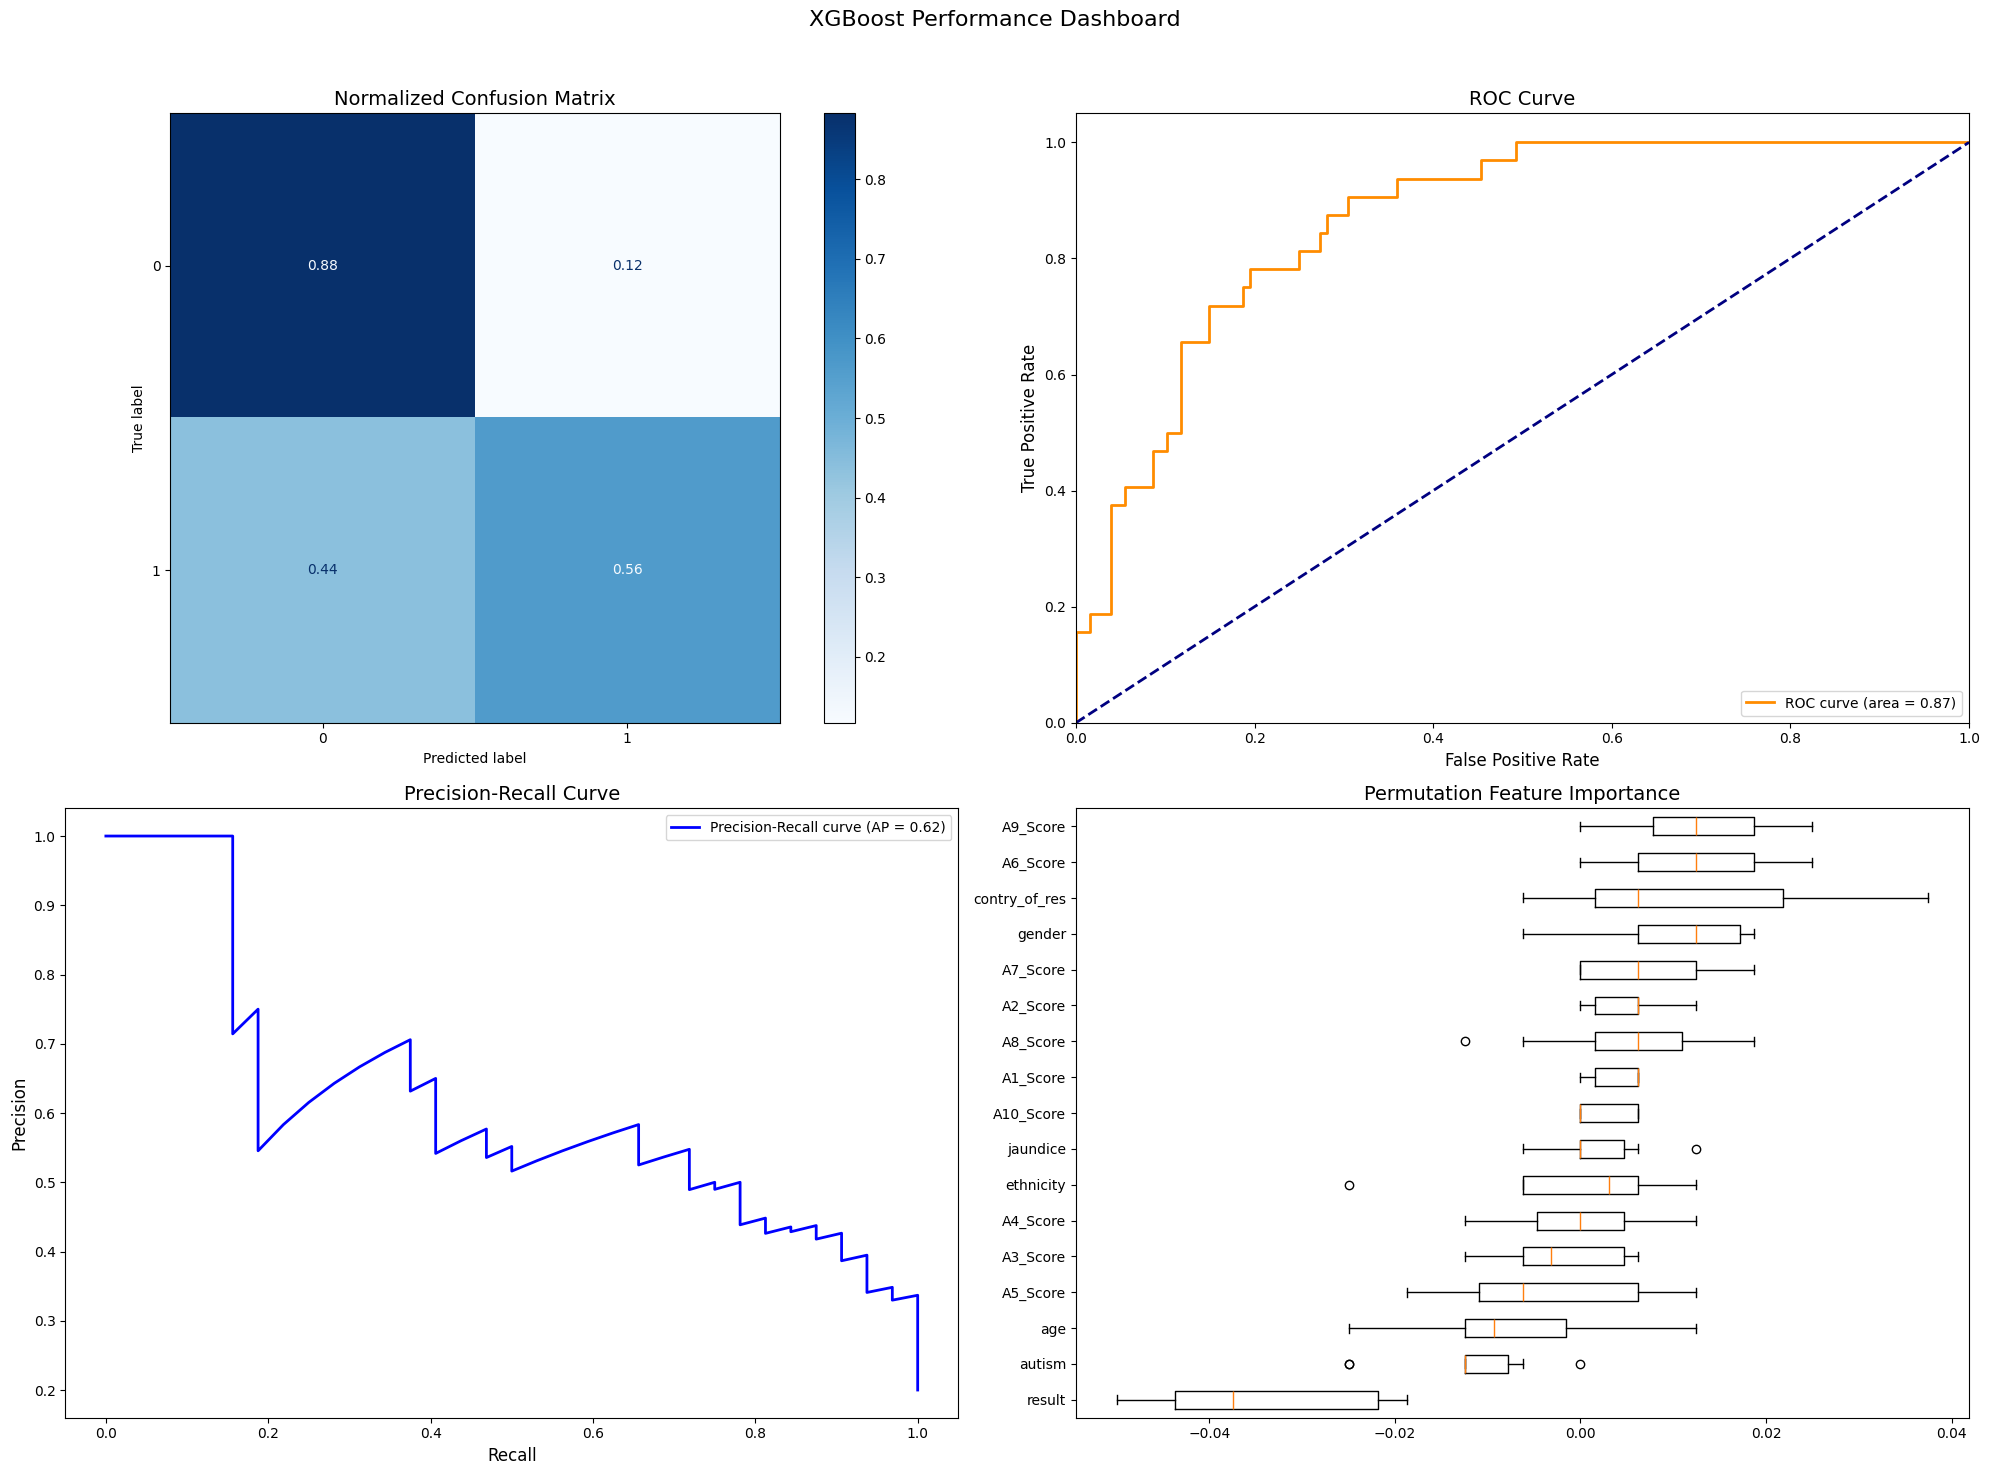

[I 2025-05-12 11:18:44,555] A new study created in memory with name: no-name-069fb853-1f5d-4067-92d7-d9d7ed55bfa5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-12 11:18:44,845] Trial 0 finished with value: 0.8306328781512604 and parameters: {'n_estimators': 932, 'max_depth': 8, 'learning_rate': 0.019094907438771444, 'subsample': 0.9418855462823269, 'colsample_bytree': 0.7504201137440738, 'min_child_weight': 6, 'gamma': 3.8789095904080244, 'reg_alpha': 5.2038037955063455e-05, 'reg_lambda': 0.3160498802134007}. Best is trial 0 with value: 0.8306328781512604.
[I 2025-05-12 11:18:45,007] Trial 1 finished with value: 0.8069514958761282 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.22392806386603795, 'subsample': 0.6862992953762427, 'colsample_bytree': 0.8611454097740072, 'min_child_weight': 1, 'gamma': 3.0467479284596024, 'reg_alpha': 1.0583972007579853e-06, 'reg_lambda': 0.0014574806657059005}. Best is trial 0 with value: 0.8306328781512604.
[I 2025-05-12 11:18:45,143] Trial 2 finished with value: 0.8204848953470276 and parameters: {'n_estimators': 327, 'max_depth': 6, 'learning_rate': 0.11828049579036468, 's

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3540441995.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


OPTIMIZED XGBOOST RESULTS:
BALANCED_ACCURACY:
  Mean: 0.8481
  Std Dev: 0.0383
  Min: 0.7812
  Max: 0.9219
ROC_AUC:
  Mean: 0.9190
  Std Dev: 0.0319
  Min: 0.8657
  Max: 0.9697
PR_AUC:
  Mean: 0.7391
  Std Dev: 0.0961
  Min: 0.5480
  Max: 0.9190
F1:
  Mean: 0.6800
  Std Dev: 0.0572
  Min: 0.5714
  Max: 0.8000
MCC:
  Mean: 0.6031
  Std Dev: 0.0740
  Min: 0.4680
  Max: 0.7490


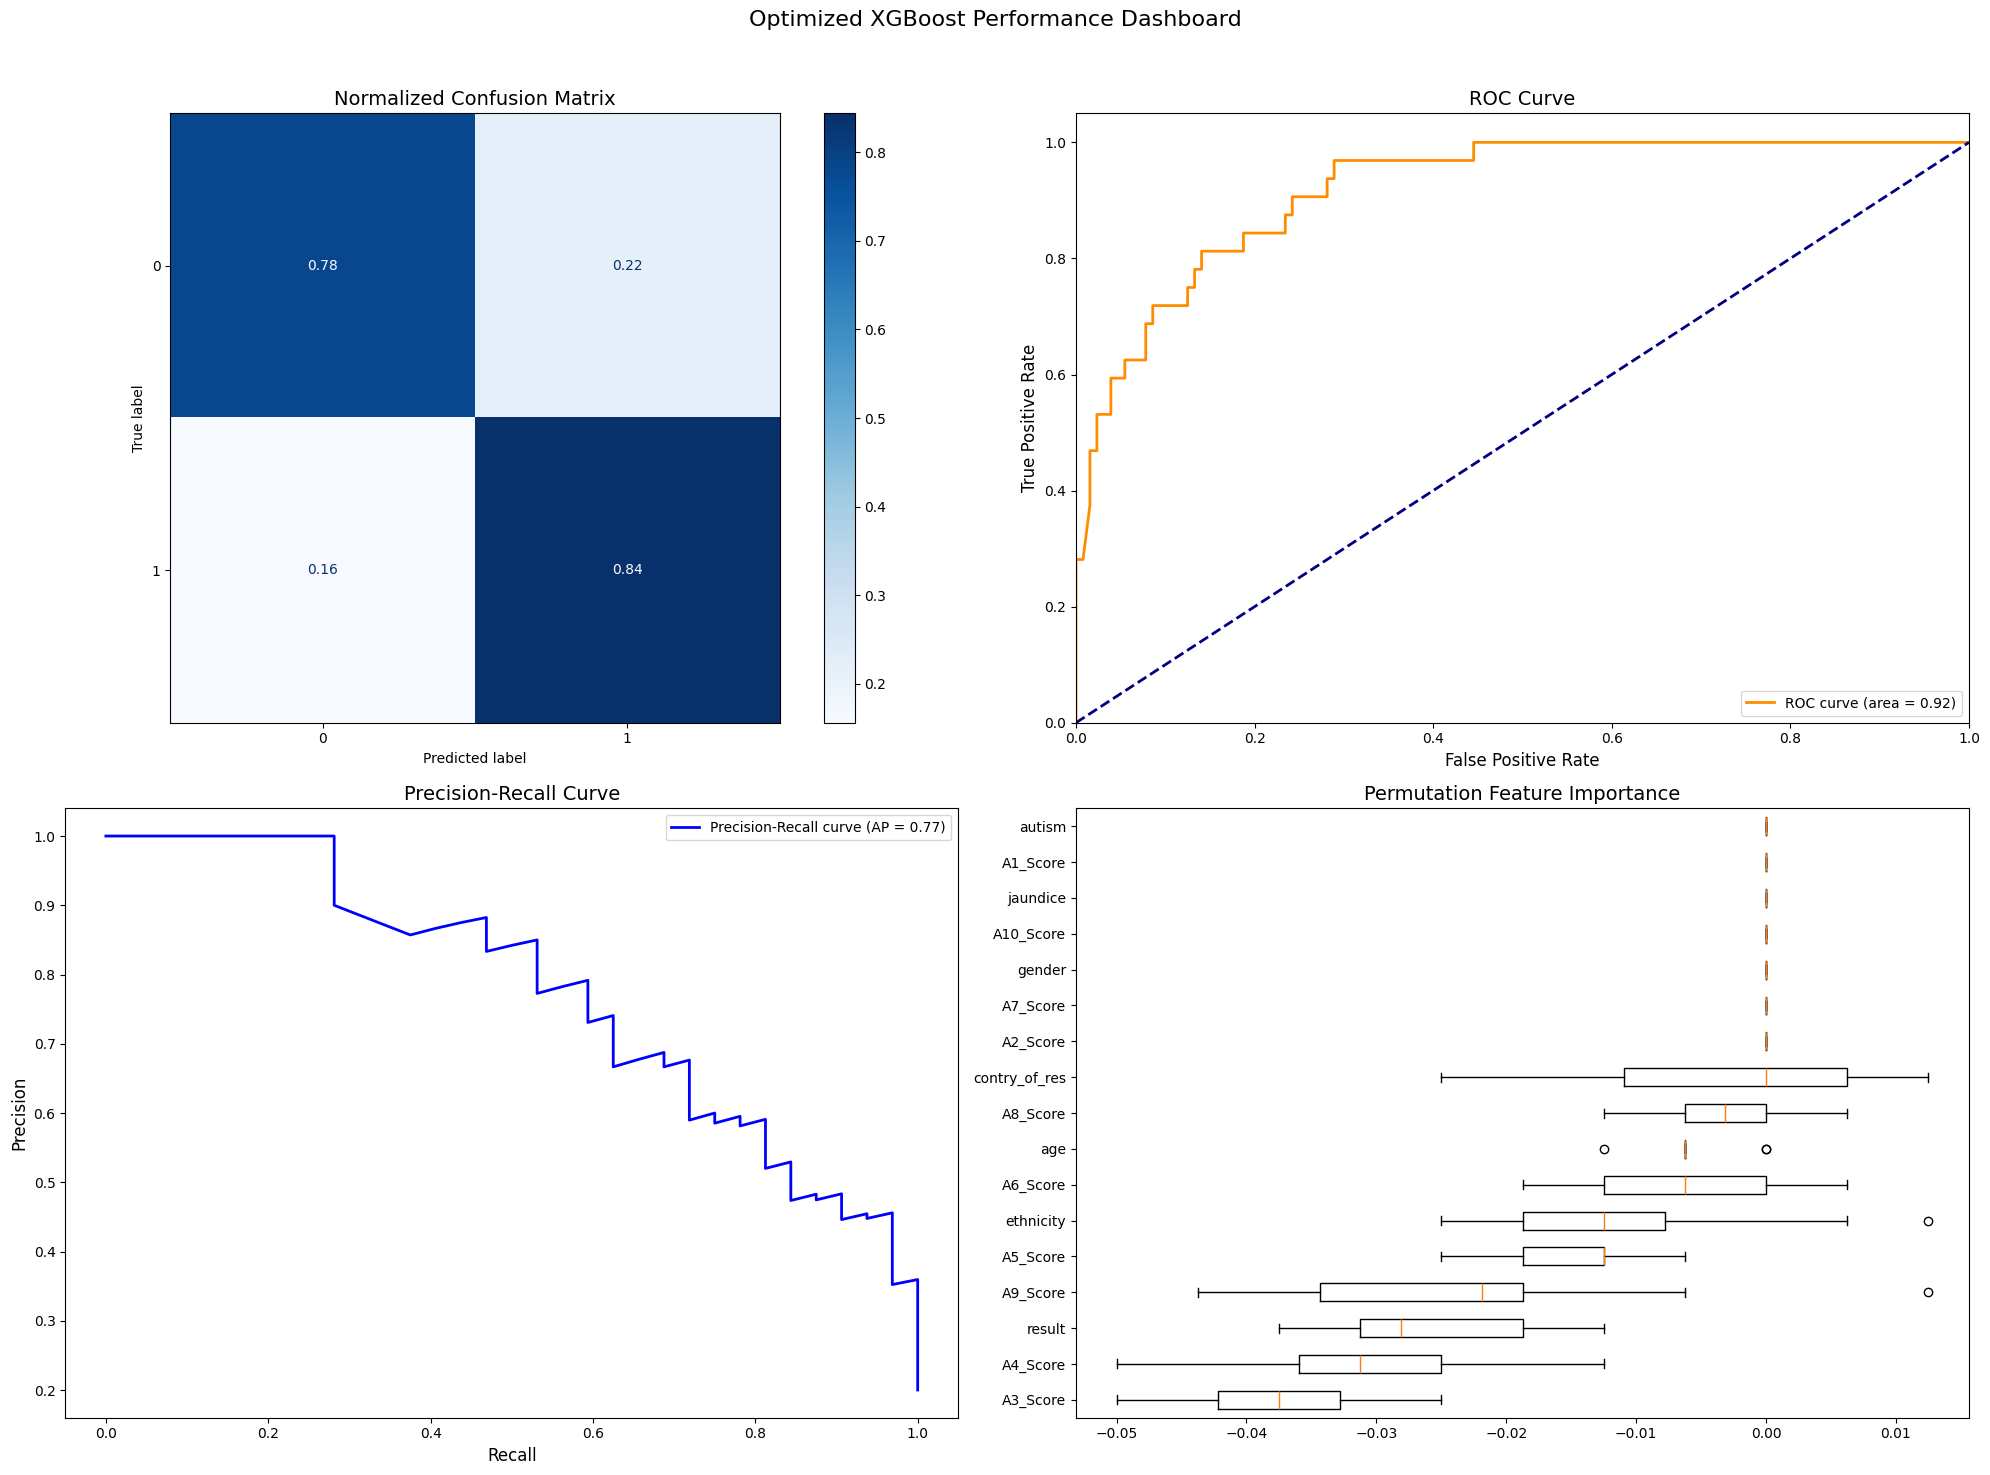


Performance Comparison (Baseline vs Optimized):
balanced_accuracy: 0.7571 → 0.8481 (+12.02%)
roc_auc: 0.8854 → 0.9190 (+3.79%)
pr_auc: 0.6382 → 0.7391 (+15.82%)
f1: 0.6090 → 0.6800 (+11.66%)
mcc: 0.5114 → 0.6031 (+17.94%)


In [23]:
# Define XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=5000,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0,        
        scale_pos_weight=neg_pos_ratio,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED,
        n_jobs=-1  # Use all cores for training
    ))
])

# Fit the model
xgb_pipeline.fit(X_train, y_train)

# Cross-validation
xgb_scores = cross_validate(
    xgb_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1  # Use all cores
)

# Create dashboard for model evaluation
create_model_dashboard(
    model=xgb_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=xgb_scores,
    scoring_dict=scoring,
    model_name="XGBoost"
)

# Create and run the optimization study
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

# Get best parameters and score
best_params = xgb_study.best_params
best_score = xgb_study.best_value
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy: {best_score:.4f}")


# Create optimized pipeline with best parameters
optimized_xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        scale_pos_weight=neg_pos_ratio,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED,
        n_jobs=-1
    ))
])

# Fit the optimized pipeline
optimized_xgb_pipeline.fit(X_train, y_train)

# Evaluate optimized model
optimized_xgb_scores = cross_validate(
    optimized_xgb_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Create dashboard for optimized model
create_model_dashboard(
    model=optimized_xgb_pipeline,
    X_test=X_test,
    y_test=y_test,
    cv_results=optimized_xgb_scores,
    scoring_dict=scoring,
    model_name="Optimized XGBoost"
)

# Compare baseline and optimized results
print("\nPerformance Comparison (Baseline vs Optimized):")
for metric in scoring.keys():
    baseline_mean = xgb_scores[f'test_{metric}'].mean()
    optimized_mean = optimized_xgb_scores[f'test_{metric}'].mean()
    improvement = ((optimized_mean - baseline_mean) / baseline_mean) * 100
    print(f"{metric}: {baseline_mean:.4f} → {optimized_mean:.4f} ({improvement:+.2f}%)")

**XGBoost Notes:** The XGBoost model showed substantial improvement post-optimization, with balanced accuracy increasing from 0.7571 to 0.8481 (+12.02%), ROC-AUC from 0.8854 to 0.9190 (+3.79%), and PR-AUC from 0.6382 to 0.7391 (+15.82%). Additional metrics also demonstrate significant gains, with F1 score improving from 0.6090 to 0.6800 (+11.66%) and Matthews Correlation Coefficient increasing from 0.5114 to 0.6031 (+17.94%). The confusion matrix reveals a dramatic improvement in the model's ability to correctly identify positive cases (from 59% to 84%), though with some increase in false positives (12% to 22%). Concerning issues appear in the feature importance plots - pre-optimization shows many features with negative or near-zero importance, while post-optimization displays several features with vertical lines rather than proper box plots, suggesting potential overfitting or instability in feature importance. The absence of meaningful variability in the feature importance measurements indicates the model may be relying too heavily on noise or spurious correlations. Next steps should include feature selection to remove uninformative variables, cross-checking feature engineering methods, and potentially implementing regularization techniques to address the apparent instability in feature importance.

## Neural Net Test

# Neural Networks
While simpler networks like Random Forest and Linear Regression work well, the magic of neural networks might give us a slight edge.

## Neural Networks Primer
The whole idea of neural networks is that we have a black box where we stick a bunch of numbers in, do random math, and get a number out. By looking at Loss (the difference between the predicted value and the real value) we can tweak the math in the neural network to get it more accurate. That simple process, when applied at scale, develops a great pattern recognition ability. If you're looking for a more in depth primer on neural networks I suggest looking [here](https://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html) or at some more recent research on LLMS [here](https://www.anthropic.com/research/tracing-thoughts-language-model)
Neural networks are wonderful for this application, as they're very strong at pattern recognition. While they're less interpretable than many other models, they could be more accurate, and if we scaled the data up more, can capture smaller harder to find patterns in the data.

## Our stuff
Neural networks are a nebulous thing, and we've tested lots of different parameters relating to layers/neurons. There isn't a huge difference, but 3 layers of roughly 32 neurons each seem to give the best performance. If we had more data to access, we'd want to scale up both of those factors.
To mitigate possible overfitting risks, we added a dropout layer, which deactivates neurons randomly during training. This forces the neural network to learn more broad patterns instead of just memorizing the training data.


We're doing some data preprocessing to get all the data as numerical values, as we can't pass anything else into the neural net.

In [24]:
# Some data preprocessing for the neural network, mainly just mapping text to numbers since that's what our neural net expects



import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

df = train.copy()

TARGET = 'Class/ASD'

# Basically just dropping country of residence
features = [col for col in df.columns if col not in [TARGET, 'contry_of_res']]

# Separate features (X) and target (y)
X = df[features]
y = df[TARGET]

# --- 3. Train-Test Split ---
# Split *before* preprocessing (like scaling and encoding) to prevent data leakage
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Added stratify

# --- 4. Preprocessing ---

# Identify column types for preprocessing
binary_cols = ['gender', 'jaundice', 'autism', 'used_app_before']
numeric_cols = ['age', 'result']
categorical_cols = ['ethnicity', 'relation']
passthrough_cols = [f'A{i}_Score' for i in range(1, 11)] # A1-A10 scores are already numerical (binary)

# Create copies to avoid SettingWithCopyWarning
x_train = x_train.copy()
x_test = x_test.copy()

# 4.1. Binary Encoding, our model only works with numerical values
for col in binary_cols:
    # Map 'yes'/'no' or 'm'/'f' to 1/0
    positive_value = 'yes' if col in ['jaundice', 'autism', 'used_app_before'] else 'm'
    x_train[col] = x_train[col].apply(lambda x: 1 if x == positive_value else 0)
    x_test[col] = x_test[col].apply(lambda x: 1 if x == positive_value else 0)

# 4.2. Scaling Numerical Features
scalers = {}
for col in numeric_cols:
    scaler = MinMaxScaler()
    # Fit on training data only
    x_train[col] = scaler.fit_transform(x_train[[col]])
    # Transform test data using the *same* scaler
    x_test[col] = scaler.transform(x_test[[col]])
    scalers[col] = scaler # Store scaler if needed later

# 4.3. One-Hot Encoding Categorical Features
# Use pd.get_dummies, ensuring consistent columns between train and test sets
x_train = pd.get_dummies(x_train, columns=categorical_cols, prefix=categorical_cols, dummy_na=False) # Set dummy_na=True if you want to explicitly handle NaNs
x_test = pd.get_dummies(x_test, columns=categorical_cols, prefix=categorical_cols, dummy_na=False)

# Align columns after one-hot encoding - handles cases where some categories only appear in train or test
train_cols = x_train.columns
test_cols = x_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    x_test[c] = 0 # Add missing columns to test set with value 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    x_train[c] = 0 # Add missing columns to train set with value 0

# Ensure the order of columns is the same
x_test = x_test[x_train.columns]

print("Preprocessing Complete.")
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Preprocessing Complete.
Training data shape: (640, 34)
Test data shape: (160, 34)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 32)                  │           1,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 5,345 (20.88 KB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6918 - auc: 0.3784 - loss: 2.1417 - val_accuracy: 0.8000 - val_auc: 0.8208 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - auc: 0.7848 - loss: 1.6287 - val_accuracy: 0.8000 - val_auc: 0.9033 - val_loss: 1.2934 - learning_rate: 0.0010
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - auc: 0.9231 - loss: 1.2104 - val_accuracy: 0.8687 - val_auc: 0.9088 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530 - auc: 0.8942 - loss: 1.0241 - val_accuracy: 0.8562 - val_auc: 0.9097 - val_loss: 0.8375 - learning_rate: 0.0010
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - auc: 0.9244 - loss: 0.7637 - val_accuracy: 0.8250 - val_auc: 0.9039 - val_loss: 0.7063 - learning_rate: 0.0010
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

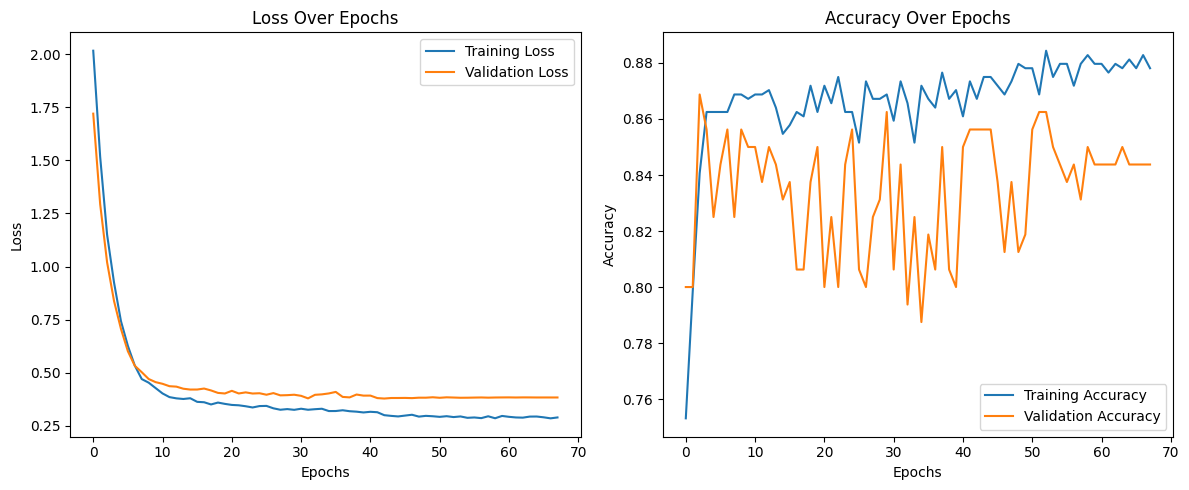

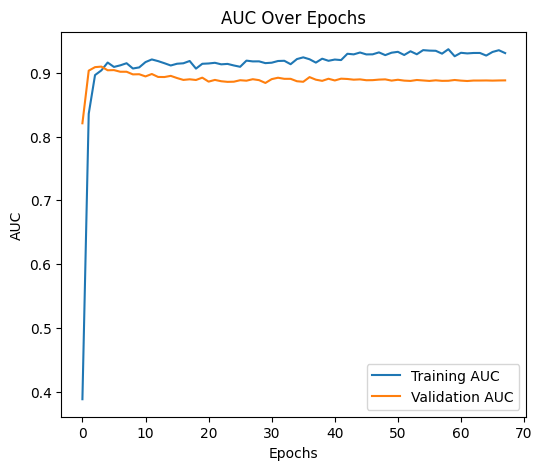

Script Finished.


In [25]:
# Model definition
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)), # Input shape based on processed features
        tf.keras.layers.Dense(32, activation="relu", name="layer1", kernel_regularizer=tf.keras.regularizers.L1(l1=0.01)),
        tf.keras.layers.Dense(64, activation="relu", name="layer2"), 
        tf.keras.layers.Dense(32, activation="relu", name="layer3"),
        tf.keras.layers.Dropout(0.3), # Dropout layer, deactivates neurons randomly during training, helps prevent overfitting
        tf.keras.layers.Dense(1, activation='sigmoid', name="output")
    ]
)

model.summary()

# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc')
    ],
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau( # If we aren't improving, reduce the learning rate (how agressively we learn)
        monitor='val_loss', 
        factor=0.2,         
        patience=10,        # Number of epochs with no improvement after which learning rate will be reduced
        verbose=1,
        min_lr=0.00001,     
    ),
    tf.keras.callbacks.EarlyStopping( # If we go a certain number of epochs without improvement, stop training
        monitor='val_loss', 
        patience=25,        
        verbose=1,
        restore_best_weights=True # Grab the best model we had
    )
]

# Model training
print("Starting model training...")
history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=200, # Unlikely we'll hit this, early stopping exists
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    verbose=1 # 0 for silent output
)

# Plotting training history
print("Plotting training history...")
plt.figure(figsize=(12, 5))

# Plot Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot AUC graph
plt.figure(figsize=(6, 5))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

print("Script Finished.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy Score: 0.7930
ROC-AUC Score: 0.8904
PR-AUC Score (Average Precision): 0.6645


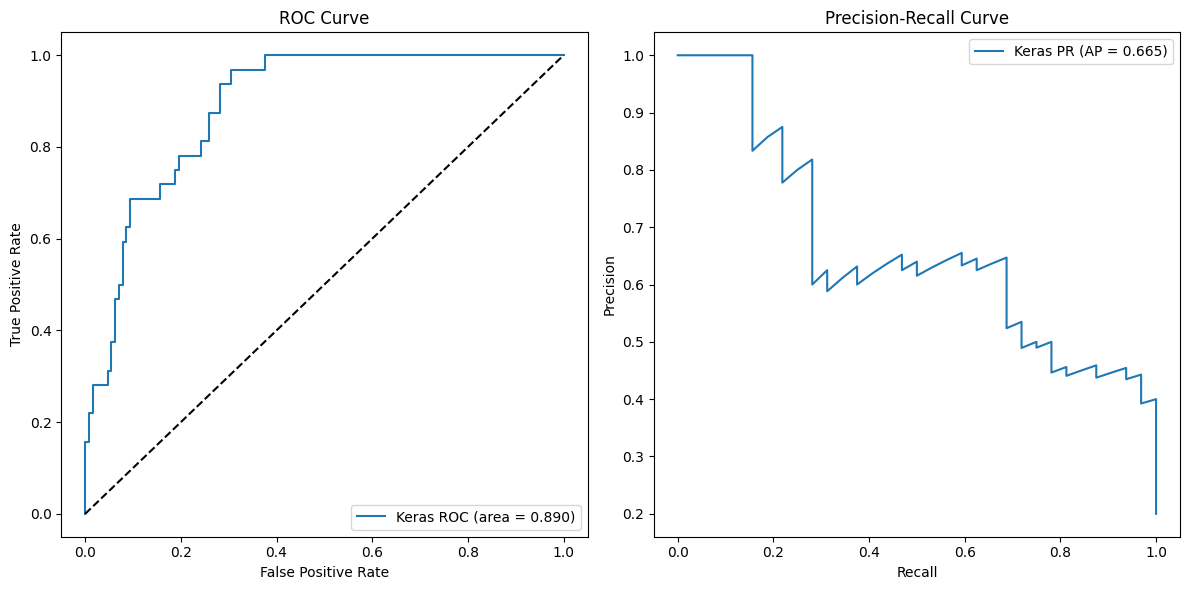

F1 Score: 0.6567
Matthews Correlation Coefficient (MCC): 0.5669


In [26]:
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, matthews_corrcoef, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

out_probs = model.predict(x_test) # These are probabilities

out_binary = (out_probs > 0.5).astype(int)

# 0. Accuracy
acc = balanced_accuracy_score(y_test, out_binary)
print(f"Accuracy Score: {acc:.4f}")

# 1. ROC Curve and ROC-AUC Score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, out_probs)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"ROC-AUC Score: {auc_keras:.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_keras, tpr_keras, label='Keras ROC (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# 2. Precision-Recall Curve and PR-AUC (Average Precision)
precision, recall, thresholds_pr = precision_recall_curve(y_test, out_probs)
pr_auc_score = average_precision_score(y_test, out_probs) # This is a common way to get PR-AUC

print(f"PR-AUC Score (Average Precision): {pr_auc_score:.4f}")


plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Keras PR (AP = {:.3f})'.format(pr_auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3. F1-Score
f1 = f1_score(y_test, out_binary)
print(f"F1 Score: {f1:.4f}")

# 4. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, out_binary)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Phase 3: Model Explainability & Fairness

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logreg, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)


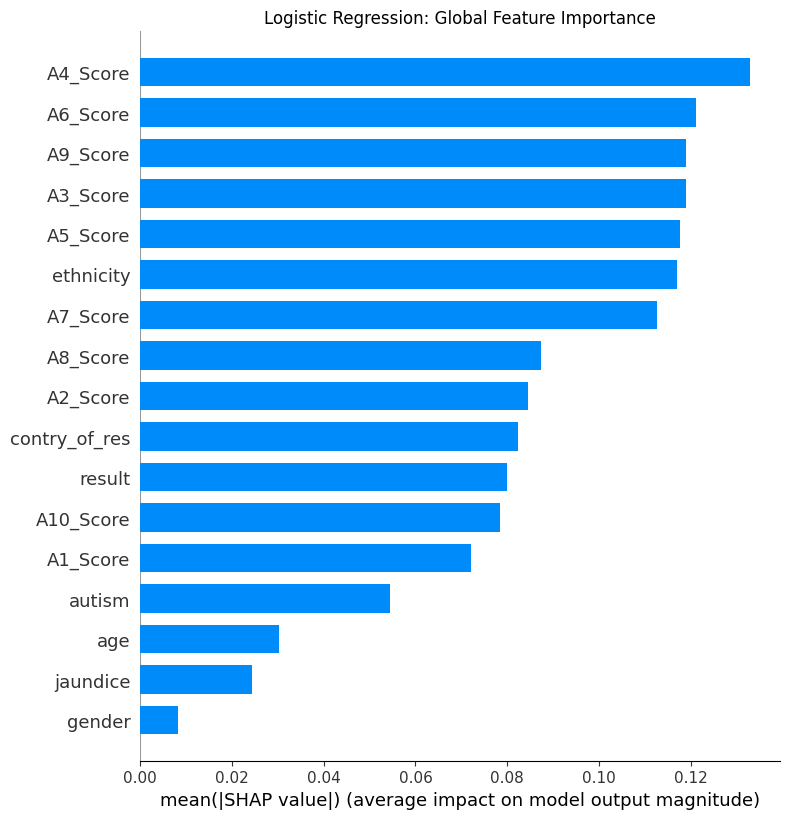

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logreg, X_test_scaled, feature_names=X_test.columns, show=False)


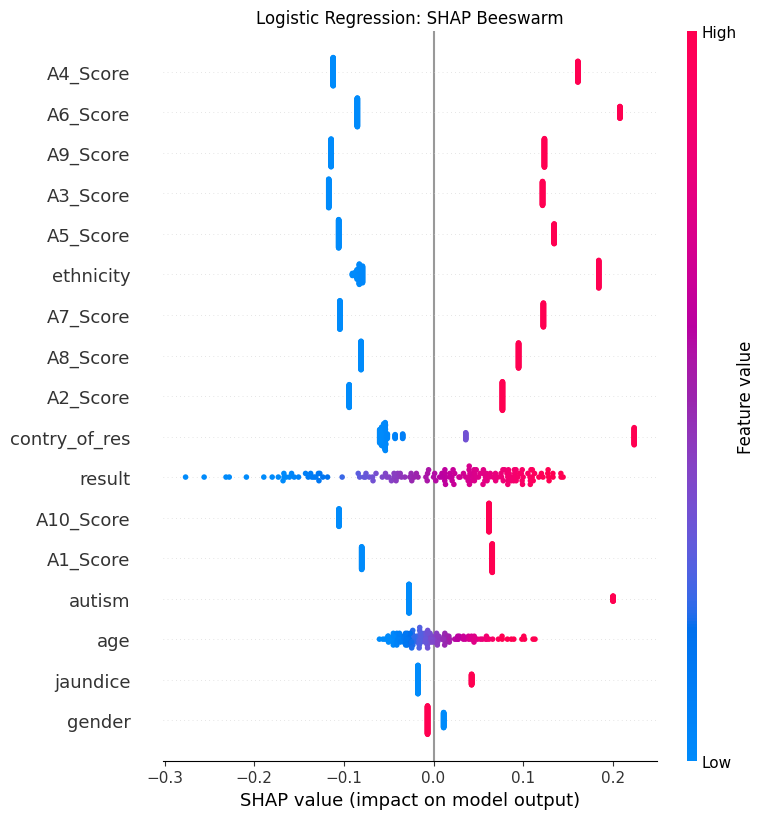

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_cat, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)


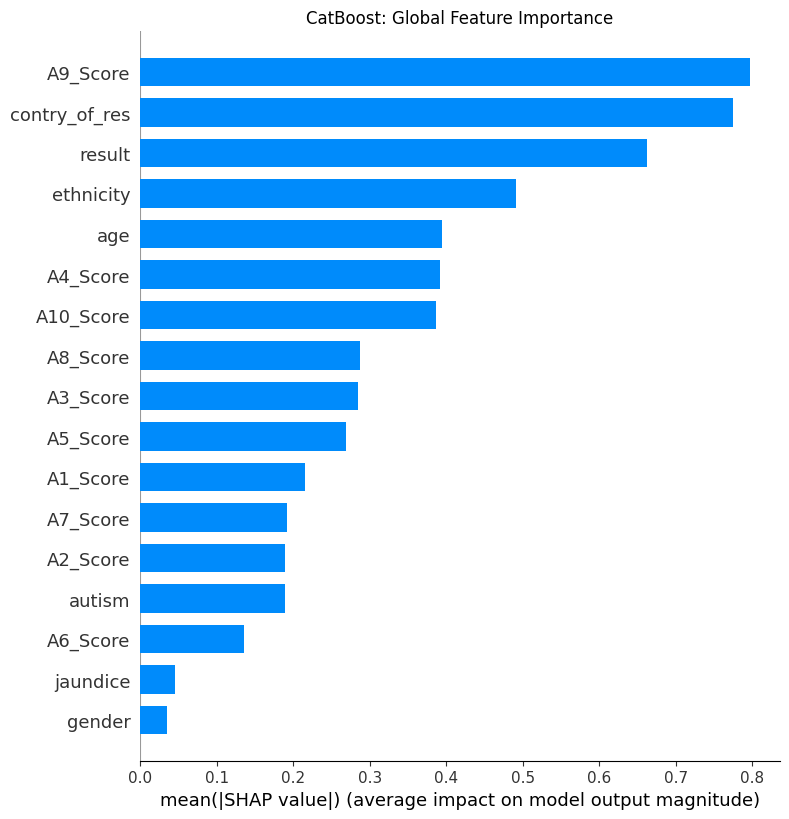

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:36: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_cat, X_test_scaled, feature_names=X_test.columns, show=False)


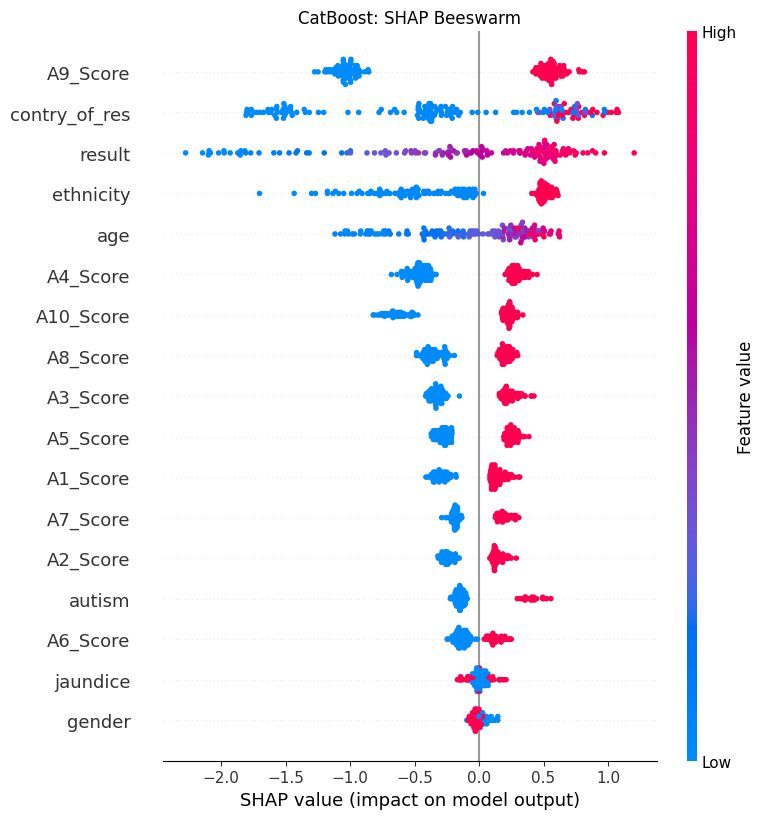

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)


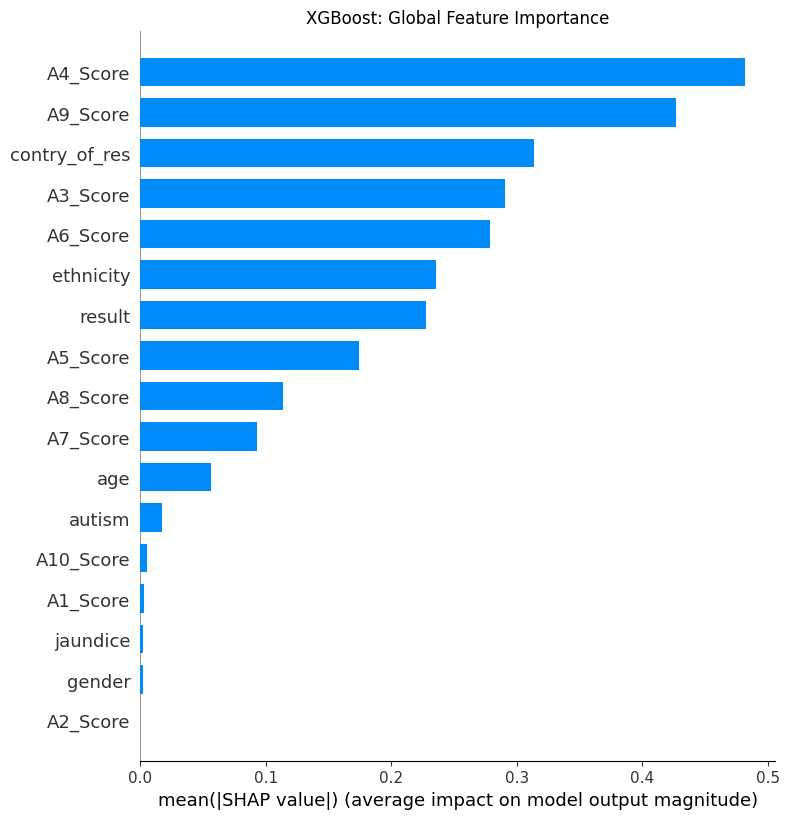

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\2890372424.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test.columns, show=False)


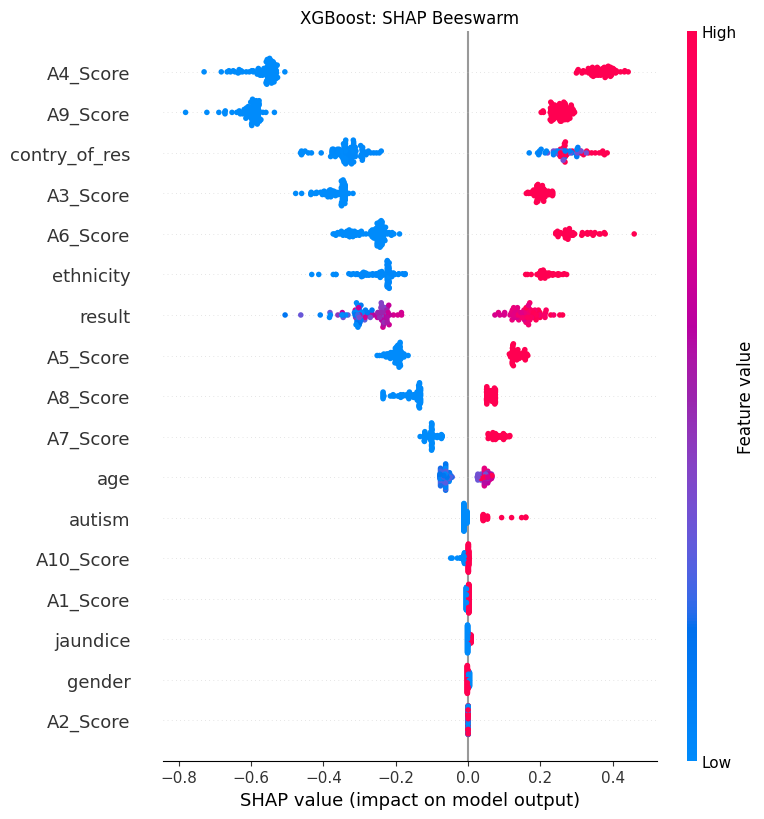

In [27]:
# 1. Scale test data as used in the pipeline
X_test_scaled = optimized_lr_pipeline.named_steps['scaler'].transform(X_test)
logreg_model = optimized_lr_pipeline.named_steps['classifier']

# 2. SHAP for linear model
explainer_logreg = shap.LinearExplainer(logreg_model, X_test_scaled)
shap_values_logreg = explainer_logreg.shap_values(X_test_scaled)

# 3. SHAP summary (bar & beeswarm)
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_logreg, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)
plt.title("Logistic Regression: Global Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_logreg, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title("Logistic Regression: SHAP Beeswarm")
plt.tight_layout()
plt.show()

# ---------- CATBOOST ----------
X_test_scaled = optimized_catboost_pipeline.named_steps['scaler'].transform(X_test)
cat_model = optimized_catboost_pipeline.named_steps['classifier']

explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat = explainer_cat.shap_values(X_test_scaled)

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_cat, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)
plt.title("CatBoost: Global Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_cat, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title("CatBoost: SHAP Beeswarm")
plt.tight_layout()
plt.show()

# ---------- XGBOOST ----------
X_test_scaled = optimized_xgb_pipeline.named_steps['scaler'].transform(X_test)
xgb_model = optimized_xgb_pipeline.named_steps['classifier']

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test.columns, plot_type='bar', show=False)
plt.title("XGBoost: Global Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title("XGBoost: SHAP Beeswarm")
plt.tight_layout()
plt.show()


Based on these SHAP graphs

x_train data type: <class 'pandas.core.frame.DataFrame'>
x_train shape: (640, 34)
After conversion, x_train dtypes: [dtype('int64') dtype('float64')]
Performing SHAP analysis...


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3071046610.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_sample, feature_names=feature_names,
C:\Users\33322\repos\asd-hackathon-25\.venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1200x800 with 0 Axes>

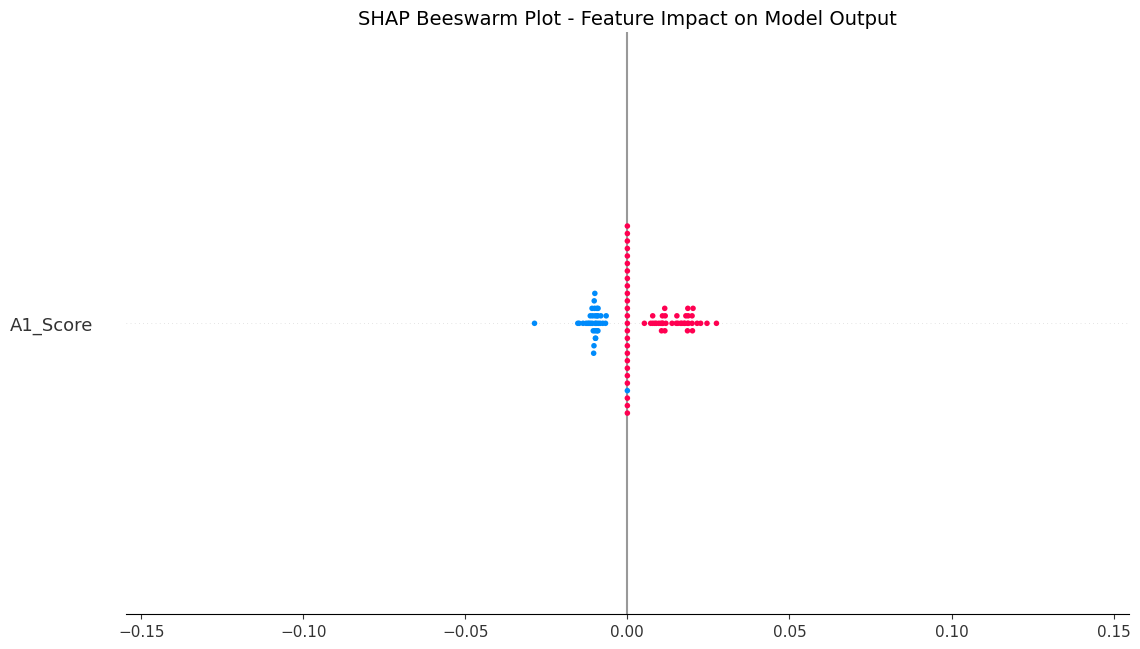

C:\Users\33322\AppData\Local\Temp\ipykernel_3708\3071046610.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_sample, feature_names=feature_names,
C:\Users\33322\repos\asd-hackathon-25\.venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1200x800 with 0 Axes>

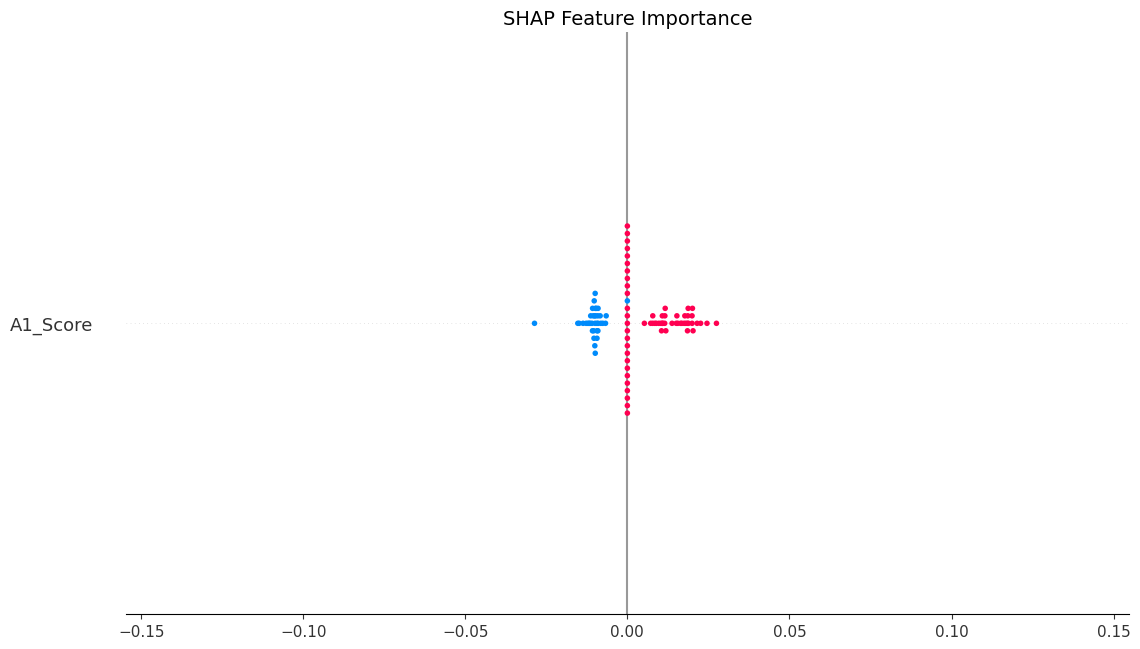

Top 10 features by SHAP importance:
          feature              importance
3        A4_Score    [0.0591264480390106]
8        A9_Score  [0.058537364482106904]
5        A6_Score   [0.05742200066204497]
2        A3_Score  [0.027178867242471923]
1        A2_Score   [0.01979908337377021]
4        A5_Score   [0.01922349843960535]
7        A8_Score   [0.01645979503266753]
32  relation_Self   [0.01318968680216386]
0        A1_Score   [0.00958192009199178]
15         result  [0.007287626326050383]
SHAP analysis complete.


In [28]:
import shap

# Let's first check the data types and shapes
print("x_train data type:", type(x_train))
print("x_train shape:", x_train.shape)

# Convert boolean columns to integers (0/1) to avoid issues
for col in x_train.columns:
    if x_train[col].dtype == bool:
        x_train[col] = x_train[col].astype(int)
        x_test[col] = x_test[col].astype(int)

print("After conversion, x_train dtypes:", x_train.dtypes.unique())

# Convert data to numpy arrays first
x_train_np = x_train.values.astype(np.float32)
x_test_np = x_test.values.astype(np.float32)

print("Performing SHAP analysis...")

# Create a background dataset for SHAP explainer (using a sample of training data)
background_size = min(100, len(x_train))
background_indices = np.random.choice(len(x_train), background_size, replace=False)
background = x_train_np[background_indices]

# For TensorFlow models, we'll use a different approach with KernelExplainer
# which is more model-agnostic but works with any model

# Create a function that uses the model to predict
def model_predict(x):
    return model.predict(x, verbose=0)

# Initialize the SHAP explainer
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values on test data (or a subset if it's large)
sample_size = min(100, len(x_test))  # Using a smaller sample size for KernelExplainer as it's more computationally intensive
sample_indices = np.random.choice(len(x_test), sample_size, replace=False)
test_sample = x_test_np[sample_indices]
shap_values = explainer.shap_values(test_sample)

# Create feature names for the plot
feature_names = x_test.columns.tolist()

# 1. SHAP Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_sample, feature_names=feature_names, 
                  plot_type="dot", show=False)
plt.title("SHAP Beeswarm Plot - Feature Impact on Model Output", fontsize=14)
plt.tight_layout()
plt.show()

# 2. SHAP Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_sample, feature_names=feature_names, 
                  plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

# 3. Calculate and display feature importance based on SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(feature_names, mean_abs_shap)), 
                                 columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 features by SHAP importance:")
print(feature_importance.head(10))

print("SHAP analysis complete.")
